<h1><b> Neural Network - Model (A) - Multilayer Perceptron, Model (B) - Support Vector Machine  </b></h1>

Import all libraries required to build the neural network and plot the graphs

In [2]:
# !pip install skorch -- to install skorch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,make_scorer,precision_score,recall_score,f1_score,roc_auc_score
import numpy as np
import pandas as pd
import torch.nn as nn   
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
import torch.nn.functional as F
from sklearn.metrics import cohen_kappa_score,plot_confusion_matrix, roc_curve,plot_roc_curve
import os
from sklearn import svm
from sklearn.model_selection import cross_val_predict
import pickle

<h1><b> EDA and data Preprocessing</b></h1>

In [3]:
#loading the dataset
nursery_data = pd.read_excel("nursery_data.xlsx")
nursery_data.head()#printing first few rows of data

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [4]:
#checking total number of rows and columns in dataset to get the overview
nursery_data.shape

(12960, 9)

So, the dataset has 12960 rows and 9 columns.This dataset includes most of the categorical columns. So let's check the number of categories each column has and the top category present for each column.

In [5]:
nursery_data.describe()

,parents,has_nurs,form,children,housing,finance,social,health,class
count,12960,12960,12960,12960,12960,12960,12960,12960,12960
unique,3,5,4,4,3,2,3,3,5
top,great_pret,improper,foster,more,convenient,convenient,slightly_prob,recommended,not_recom
freq,4320,2592,3240,3240,4320,6480,4320,4320,4320


The above data shows that the class column which is the output column(whoes value has to be predicted by training the neural model) has got 5 different categories. Let's check the count for each category

<AxesSubplot:xlabel='class', ylabel='count'>

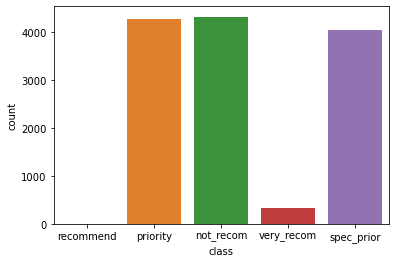

In [6]:
#to plot output class distribution
sns.countplot(x = 'class', data=nursery_data)

As the class - "recommend" has count very very less then the rest of the classes so, simply removing this class for simplification purpose. 

<AxesSubplot:xlabel='class', ylabel='count'>

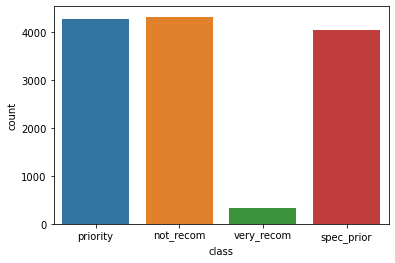

In [7]:
# nursery_data.drop[nursery_data[nursery_data["class"]=="recommend"].index,inplace=True]
nursery_data.drop(nursery_data[nursery_data['class'] == "recommend"].index, inplace = True)

sns.countplot(x = 'class', data=nursery_data)

Now we have four output labels named - 
1) priority
2) not_recom
3) very_recom
4) spec_prior

As pytorch supports labels from 0. So, we will do encoding of the output labels.
We, will use replace() method from pandas library to convert 

In [8]:
#encoding of output classes 

labels2idx = {
    "priority":0,
    "not_recom":1,
    "very_recom":2,
    "spec_prior":3
}

#to convert the ids back into the original classes
idx2labels = {index: label for label, index in labels2idx.items()}

nursery_data['class'].replace(labels2idx, inplace=True)

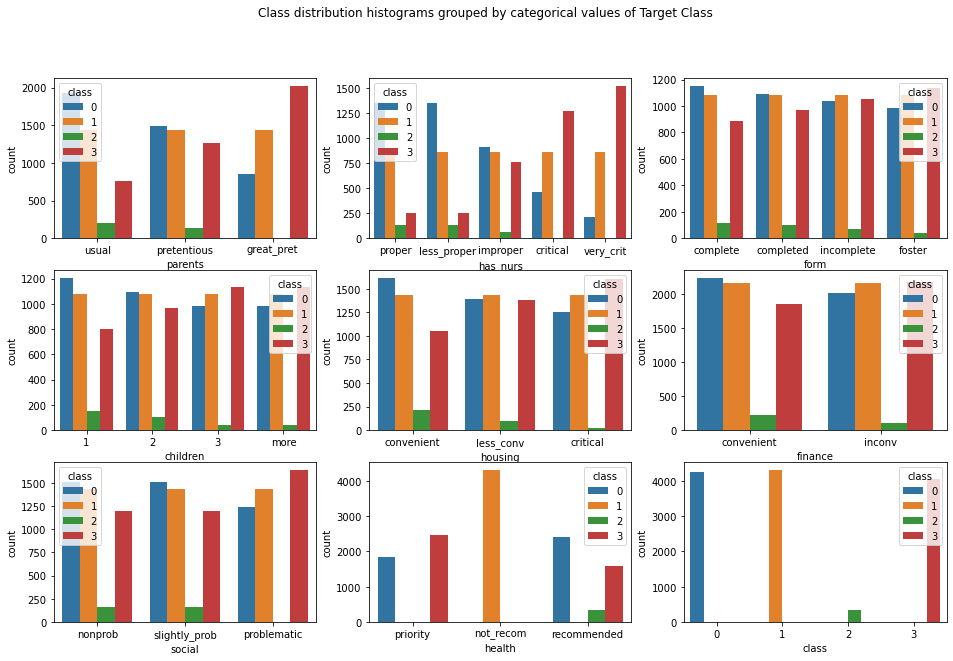

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(16,10))

fig.suptitle('Class distribution histograms grouped by categorical values of Target Class')

sns.countplot(ax=axes[0, 0], data=nursery_data, x='parents', hue = "class")
# axes[0,0].set_title(squirtle.name)
sns.countplot(ax=axes[0, 1], data=nursery_data, x='has_nurs', hue = "class")
sns.countplot(ax=axes[0, 2], data=nursery_data, x='form', hue = "class")
sns.countplot(ax=axes[1, 0], data=nursery_data, x='children', hue = "class")
sns.countplot(ax=axes[1, 1], data=nursery_data, x='housing', hue = "class")
sns.countplot(ax=axes[1, 2], data=nursery_data, x='finance', hue = "class")
sns.countplot(ax=axes[2, 0], data=nursery_data, x='social', hue = "class")
sns.countplot(ax=axes[2, 1], data=nursery_data, x='health', hue = "class")
sns.countplot(ax=axes[2, 2], data=nursery_data, x='class', hue = "class")
plt.show()

<h2><b> Data Transformation </b></h2>

converting the datatype of column children into string. This column contains value for total number of children each parent has
who has applied for admission in nursery. Fews rows contains values like more which indicates a parent having more then three childre. So, this column needed be converted into string so can be done label encoding in futhur step.

In [10]:
nursery_data["children"] = str(nursery_data["children"])

In [11]:
#label encoding for all categorical input variables
categorical_columns = ["parents", "has_nurs", "form", "housing", "finance","social","health","children"] #listing all categorical columns
encoders = {}
for col in categorical_columns:
        encoders[col] = LabelEncoder()
        nursery_data[col] = encoders[col].fit_transform(nursery_data[col])
nursery_data.head()        

,parents,has_nurs,form,children,housing,finance,social,health,class
1,2,3,0,0,0,0,0,1,0
2,2,3,0,0,0,0,0,0,1
4,2,3,0,0,0,0,2,1,0
5,2,3,0,0,0,0,2,0,1
6,2,3,0,0,0,0,1,2,0


In [12]:
nursery_data.shape

(12958, 9)

After label encoding we will split our data into test and train set. As the dataset is imbalanced so to have equal distribution in test and train set, stratify option will be used.

In [13]:
input_data = nursery_data.drop(['class'],axis=1)
output_data = nursery_data['class']

#splitting dataset into test and train set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25,stratify=output_data) #25% of dataset will be used to test the neural network

In [14]:
X_train.shape #this will be used to train the neural network, which is 70% of the total data

(9718, 8)

In [15]:
X_test.shape #this will be used to test the neural network which is 25% of total data

(3240, 8)

Neural network needs data that are in range of 0 to 1. So to scale the data MinMaxScaler function will be used.

In [16]:
#Neural networks need data that lies between the range of (0,1), so we will normalize our input data using MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#checking the data type of X_train
type(X_train)

numpy.ndarray

In [18]:
# #as pytorch doesnot accept dataframe as input so changing type from data frame to numpy
# X_train = X_train.to_numpy()
# type(X_train)

In [19]:
#checking the data type of y_train
type(y_train)

pandas.core.series.Series

In [20]:
#as pytorch doesnot accept dataframe as input so changing type from data frame to numpy
y_train = y_train.to_numpy()
type(y_train)

numpy.ndarray

In [21]:
#checking data type for X_test
type(X_test)

numpy.ndarray

In [22]:
#checking datatype for y_test
type(y_test)

pandas.core.series.Series

In [23]:
#changing datatype for y_test to numpy
y_test = y_test.to_numpy()

Lets visualize the distribution of output labels in our test and train set

Text(0.5, 1.0, 'Output label Distribution in Test Set')

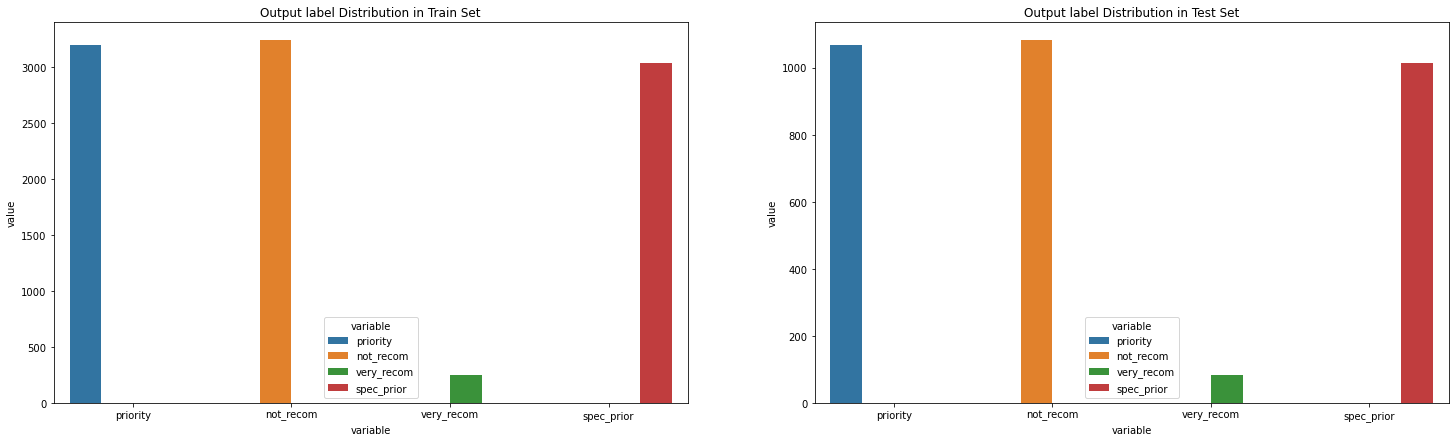

In [24]:
#this function contains output labels and their counts which are initially initialised to 0.
#this function contains output labels and their counts which are initially initialised to 0.
def output_label_distribution(train_test_set):
    count = {
        "priority":0,
        "not_recom":1,
        "very_recom":2,
        "spec_prior":3
        
    }
    
    for label in train_test_set:
        if label == 0: 
            count['priority'] += 1
        elif label == 1: 
            count['not_recom'] += 1
        elif label == 2: 
            count['very_recom'] += 1
        elif label == 3: 
            count['spec_prior'] += 1                
        
            
    return count


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))

# Train
sns.barplot(data = pd.DataFrame.from_dict([output_label_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Output label Distribution in Train Set')

# Test
sns.barplot(data = pd.DataFrame.from_dict([output_label_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Output label Distribution in Test Set')

In [25]:
#converting the data type, as pytorch has a specific type of datatype in order to train the neural network
train_dataset = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()
test_dataset = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()

In [26]:
train_dataset

(tensor([[0.0000, 0.2500, 0.0000,  ..., 0.0000, 0.0000, 0.5000],
         [0.5000, 0.5000, 0.3333,  ..., 0.0000, 1.0000, 0.5000],
         [0.0000, 0.5000, 1.0000,  ..., 0.0000, 0.0000, 1.0000],
         ...,
         [1.0000, 0.5000, 0.3333,  ..., 0.0000, 1.0000, 0.0000],
         [1.0000, 0.7500, 0.3333,  ..., 0.0000, 1.0000, 1.0000],
         [0.5000, 0.5000, 0.6667,  ..., 0.0000, 0.5000, 0.0000]]),
 tensor([3, 0, 0,  ..., 1, 0, 1]))

In [27]:
#let's check the count for each classes in the output before oversampling has been done
counter = Counter(y_train)
print(counter)

Counter({1: 3240, 0: 3199, 3: 3033, 2: 246})


As, there is a class imbalance so we will oversample the minority class. We will use Synthetic Minority Oversampling Technique, called  SMOTE

In [28]:
# transform the dataset
sm = SMOTE(k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [29]:
#lets check the count for each class type in train set after oversampling has been done
counter = Counter(y_train_res)
print(counter)

Counter({3: 3240, 0: 3240, 1: 3240, 2: 3240})


In [30]:
type(X_train_res)#check the datatype of train sampled data to make sure it is of numpy, as torch accepts numpy data

numpy.ndarray

In [31]:
train_res_data = torch.tensor(X_train_res,dtype=torch.float),torch.tensor(y_train_res,dtype=torch.float)

Let's check if gpu is active. If it is not active then set device to cpu

In [32]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)    

cpu


<h1> MODEL -A)  MLP </h1>

Defining the basic structure of the mlp model with 8 inputs and 4 outputs. Using LeakyReLU as an activation function. Setting drop (drop) to 0.5  and number of hidden layers(num_units) to 14

In [33]:

class MulticlassClassification(nn.Module):
    def __init__(self,num_units=14,nonlin=F.relu,drop=.5):
        super(MulticlassClassification,self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(8,num_units),
            nn.LeakyReLU(),
            nn.Dropout(p=drop),
            nn.Linear(num_units,4),
        )
        
    def forward(self,X):
        X = self.module(X)
        return X

Wrapping the neural net into skorch classifier. Setting maximum epoch to 1000, learning rate to 0.1, device to cpu, loss criteria to cross entropy loss, optimizer learning rate to 0.005, optimizer weight decay to 0.01 and using Adam optimizer. Early stopping criteria implemented to prevent over fitting

In [34]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MulticlassClassification(num_units = 18),
    max_epochs=1000, #maximum epoch
    lr=0.1, #learning rate
    device=device, #device = cpu
    callbacks=[EarlyStopping()], #early stopping criteria used
    criterion=nn.CrossEntropyLoss, #loss function
    optimizer=torch.optim.Adam, #optimizer type
    optimizer__lr = .005, #optimizer learning rate
    optimizer__weight_decay=0.01, #optimizer weight decay
)

<H2> Hyper- Parameter tuning </H2>

Basic Tuning with only maximum epoch and learning rate. Scoring factor kept as F1 score. Random search is used to get the best parameters

In [34]:
#specifying parameters for random search
parameters ={
    'lr':[0.0007,0.0008,0.0009,0.0010,0.0011,0.0020,0.0030,0.01,0.1,0.05],
    'max_epochs':[300,350,400,450,500,1000,1500,2000],
}

scoring = {
           'f1_score': make_scorer(f1_score, average = 'weighted')
           } 
rs = RandomizedSearchCV(net,parameters,cv=5,scoring=scoring,refit = 'f1_score') #calling random search
search = rs.fit(torch.from_numpy(X_train_res).float(), torch.from_numpy(y_train_res).long()) #fitting and saving model into search variable
print(search.best_score_,search.best_params_) #getting best paramters and best score

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5586       0.4301        1.2977  0.2628
      2        1.3635       0.5077        1.1233  0.2296
      3        1.2121       0.5087        0.9814  0.2599
      4        1.0658       0.5530        0.9128  0.2482
      5        0.9877       0.5077        0.9439  0.2370
      6        0.9853       0.5381        0.8800  0.2328
      7        0.9555       0.5632        0.8576  0.2610
      8        0.9379       0.5400        0.8605  0.2924
      9        0.9340       0.6336        0.7956  0.2989
     10        0.9358       0.5670        0.8972  0.2436
     11        0.9359       0.5704        0.8714  0.2502
     12        0.9277       0.5747        0.8384  0.2360
     13        0.9178       0.6524        0.7652  0.2290
     14        0.8726       0.6427        0.7942  0.2390
     15        0.8809       0.6258        0.8016  0.2526
     16        0.8873       0.6

      8        0.9452       0.5752        0.8670  0.2484
      9        0.9282       0.6345        0.8078  0.2347
     10        0.8993       0.6138        0.8269  0.2463
     11        0.8953       0.6008        0.8306  0.2251
     12        0.8965       0.5868        0.8508  0.2365
     13        0.9137       0.6244        0.7996  0.2792
     14        0.8825       0.6403        0.7972  0.2205
     15        0.8742       0.6017        0.8210  0.2762
     16        0.8903       0.6109        0.8160  0.2560
     17        0.8858       0.6075        0.8105  0.3190
     18        0.8783       0.6128        0.8098  0.3570
     19        0.8809       0.6591        0.7680  0.2921
     20        0.8571       0.6278        0.8103  0.2443
     21        0.8701       0.6099        0.8168  0.2449
     22        0.8729       0.6336        0.7857  0.2890
     23        0.8577       0.6635        0.7646  0.2470
     24        0.8517       0.6143        0.8193  0.2410
     25        0.8712       0.6

     10        0.8967       0.6196        0.8256  0.2414
     11        0.9085       0.5839        0.8569  0.2325
     12        0.9100       0.5955        0.8256  0.3238
     13        0.8933       0.5950        0.8250  0.2335
     14        0.8922       0.6017        0.8152  0.2676
     15        0.8854       0.6504        0.7768  0.2548
     16        0.8649       0.6196        0.8108  0.2733
     17        0.8819       0.6543        0.7734  0.2578
     18        0.8626       0.5979        0.8331  0.2446
     19        0.8784       0.6292        0.7870  0.2494
     20        0.8619       0.6172        0.8082  0.2382
     21        0.8682       0.6254        0.7935  0.2464
     22        0.8645       0.6774        0.7446  0.2367
     23        0.8408       0.5974        0.8484  0.2616
     24        0.8783       0.6205        0.7920  0.2393
     25        0.8640       0.6620        0.7605  0.2340
     26        0.8412       0.6133        0.8197  0.2416
Stopping since valid_loss has n

     11        0.9019       0.5882        0.8403  0.3484
     12        0.9060       0.5824        0.8434  0.3450
     13        0.9077       0.6432        0.7752  0.3500
     14        0.8650       0.6027        0.8199  0.3501
     15        0.8946       0.6422        0.7790  0.3303
     16        0.8676       0.6278        0.8164  0.3524
     17        0.8787       0.6022        0.8068  0.3318
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5499       0.4291        1.2912  0.3042
      2        1.3530       0.5231        1.1264  0.2957
      3        1.2342       0.5058        0.9904  0.2832
      4        1.0708       0.5559        0.9139  0.2857
      5        0.9907       0.5357        0.8943  0.2937
      6        0.9707       0.5140        0.9128  0.3011
      7        0.9601       0.5771        0.8494  0.3061
      8        0.9738  

      2        1.3506       0.5391        1.1235  0.2791
      3        1.1735       0.5130        1.0138  0.2933
      4        1.0630       0.5545        0.9723  0.3116
      5        0.9905       0.5188        1.0006  0.2860
      6        0.9873       0.5535        0.9163  0.3179
      7        0.9406       0.5974        0.8710  0.3033
      8        0.9288       0.5685        0.9206  0.3096
      9        0.9338       0.5685        0.8891  0.2896
     10        0.9286       0.6384        0.7954  0.2915
     11        0.8792       0.5950        0.8429  0.3213
     12        0.9039       0.6022        0.8230  0.2934
     13        0.8915       0.6041        0.8163  0.2853
     14        0.8924       0.6278        0.7970  0.2834
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5555       0.4499        1.2901  0.2922
      2        1.3421  

     15        0.8664       0.6263        0.8121  0.3085
     16        0.8954       0.6152        0.7901  0.3065
     17        0.8720       0.6061        0.8020  0.3255
     18        0.8827       0.6581        0.7503  0.2945
     19        0.8591       0.6365        0.7874  0.2755
     20        0.8682       0.6495        0.7725  0.3152
     21        0.8637       0.6413        0.7895  0.3300
     22        0.8657       0.6384        0.7853  0.2803
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5567       0.4339        1.2977  0.2894
      2        1.3552       0.4981        1.1229  0.2822
      3        1.2245       0.5034        1.0046  0.2835
      4        1.0604       0.5347        0.9219  0.3213
      5        1.0031       0.5482        0.8861  0.2805
      6        0.9921       0.5082        0.9427  0.2954
      7        0.9704  

     11        0.8920       0.5984        0.8374  0.3015
     12        0.8926       0.5892        0.8398  0.2921
     13        0.9047       0.5969        0.8211  0.3259
     14        0.8957       0.6509        0.7846  0.2905
     15        0.8640       0.6095        0.8319  0.2695
     16        0.8794       0.5993        0.8147  0.2937
     17        0.8855       0.5993        0.8101  0.3128
     18        0.8841       0.6393        0.7810  0.2925
     19        0.8670       0.6533        0.7801  0.2981
     20        0.8511       0.6533        0.7895  0.3227
     21        0.8652       0.5979        0.8226  0.2916
     22        0.8675       0.6176        0.7952  0.3081
     23        0.8755       0.6046        0.8076  0.2828
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5451       0.4248        1.2959  0.2878
      2        1.3470  

      3        1.2059       0.5477        0.9728  0.2929
      4        1.0416       0.5622        0.9351  0.2917
      5        0.9970       0.5096        1.0242  0.3407
      6        1.0021       0.5583        0.8916  0.3858
      7        0.9495       0.5636        0.8830  0.3260
      8        0.9444       0.5878        0.8475  0.3833
      9        0.9184       0.6326        0.8134  0.2984
     10        0.9019       0.6172        0.8246  0.4033
     11        0.9002       0.6172        0.8078  0.3177
     12        0.8916       0.5974        0.8321  0.2961
     13        0.8972       0.6051        0.8126  0.2917
     14        0.8883       0.6495        0.7835  0.3456
     15        0.8706       0.6138        0.8106  0.2975
     16        0.8805       0.6258        0.7964  0.2956
     17        0.8723       0.6003        0.8117  0.3213
     18        0.8787       0.6596        0.7682  0.3380
     19        0.8568       0.6143        0.8052  0.4779
     20        0.8681       0.6

     12        0.9071       0.5839        0.8266  0.3208
     13        0.8954       0.5945        0.8128  0.2729
     14        0.8882       0.5868        0.8297  0.3314
     15        0.8897       0.5926        0.8157  0.3420
     16        0.8857       0.6210        0.8057  0.2898
     17        0.8987       0.5762        0.9052  0.3270
     18        0.9255       0.5839        0.8612  0.2874
     19        0.9004       0.5993        0.8065  0.2829
     20        0.8782       0.5926        0.8230  0.2622
     21        0.8753       0.6234        0.7975  0.3153
     22        0.8674       0.6123        0.7979  0.2998
     23        0.8666       0.6408        0.7890  0.3260
     24        0.8596       0.5955        0.8249  0.3502
     25        0.8610       0.6442        0.7859  0.3249
     26        0.8621       0.6181        0.7932  0.2945
     27        0.8507       0.6027        0.8160  0.3434
     28        0.8589       0.6480        0.7713  0.3650
     29        0.8432       0.6

      2        1.3513       0.5227        1.1056  0.3504
      3        1.2083       0.5077        0.9790  0.3097
      4        1.0495       0.5391        0.9150  0.3155
      5        0.9868       0.5029        0.9442  0.2927
      6        0.9860       0.5559        0.8663  0.3139
      7        0.9398       0.5574        0.8642  0.3017
      8        0.9260       0.6384        0.8321  0.2780
      9        0.9337       0.5453        0.9356  0.2927
     10        0.9407       0.5704        0.8704  0.2864
     11        0.9137       0.5762        0.8401  0.2884
     12        0.8946       0.6302        0.8032  0.2996
     13        0.8846       0.5853        0.8347  0.3038
     14        0.8863       0.6225        0.8104  0.3035
     15        0.8808       0.5805        0.8465  0.2913
     16        0.8855       0.6225        0.8043  0.2958
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  

     20        0.8756       0.6162        0.8161  0.3523
     21        0.8811       0.5969        0.8228  0.3086
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5636       0.4470        1.2880  0.3079
      2        1.3530       0.5193        1.1243  0.3014
      3        1.2364       0.5068        0.9951  0.2825
      4        1.0658       0.5434        0.9122  0.3300
      5        0.9893       0.5217        0.9118  0.2972
      6        0.9733       0.5959        0.8580  0.2994
      7        0.9399       0.5294        0.9142  0.3151
      8        0.9849       0.5265        0.9551  0.2944
      9        0.9672       0.5728        0.8592  0.3015
     10        0.9253       0.5791        0.8457  0.3012
     11        0.9091       0.6403        0.8100  0.3252
     12        0.8929       0.5873        0.8386  0.3107
     13        0.8923  

In [35]:
# save the model to disk in pickle file
filename = 'mlp_basic.sav'
pickle.dump(search, open(filename, 'wb'))


# load the model from disk
search = pickle.load(open(filename, 'rb'))

Plotting loss curve to visualize the train and test loss

In [36]:
train_loss = search.best_estimator_.history[:,'train_loss'] #getting value for train loss
valid_loss = search.best_estimator_.history[:,'valid_loss'] #getting value for test loss

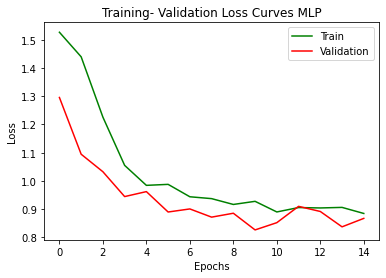

In [37]:
#getting number of epochs
epochs = [i for i in range(len(search.best_estimator_.history))]
plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');

#setting title, x axis labels , legend and y axis label
plt.title('Training- Validation Loss Curves MLP'); 
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend(['Train','Validation']);

Considering more parameters to get better trained model. passing hidden unints, optimizer type and drop rate into random search to get the best parameters based on their F1-score

In [ ]:
#specifying parameters for random search
parameters ={
    'lr':[0.0007,0.0008,0.0009,0.0010,0.0011,0.0020,0.0030,0.01,0.1,0.05],#learning rate
    'max_epochs':[300,350,400,450,500,1000,1500,2000],#max epoch
    'module__num_units':[6,8,10,12,14,16,20],#no. of hidden layers
    'module__drop' : [0,.1,.2,.3,.4,.0007,.0001,.0004,.004,.007,.01,.0001], #drop rate
    'optimizer': [torch.optim.SGD, torch.optim.Adam],#optimizer type 
    
}

scoring = {
          'f1_score': make_scorer(recall_score, average = 'weighted') #using f1-score as a scoring parameter
           } 
rs2 = RandomizedSearchCV(net,parameters,cv=5,scoring=scoring,refit = 'f1_score')#doing random search on parameters
model = rs2.fit(torch.from_numpy(X_train_res).float(), torch.from_numpy(y_train_res).long())#fitting model
print(model.best_score_,model.best_params_)#getting best scores and paramters

Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4071       0.1958        1.4023  0.3613
      2        1.3969       0.2338        1.3928  0.3803
      3        1.3880       0.2681        1.3844  0.3611
      4        1.3801       0.2989        1.3770  0.3545
      5        1.3730       0.3375        1.3702  0.3610
      6        1.3664       0.3529        1.3637  0.3431
      7        1.3600       0.3751        1.3574  0.2984
      8        1.3539       0.3886        1.3513  0.4110
      9        1.3478       0.4031        1.3451  0.3583
     10        1.3415       0.4147        1.3387  0.3841
     11        1.3351       0.4229        1.3321  0.3516
     12        1.3282       0.4320        1.3252  0.3387
     13        1.3212       0.

     97        0.7446       0.6996        0.7448  0.3298
     98        0.7421       0.7001        0.7427  0.3224
     99        0.7401       0.7011        0.7407  0.3584
    100        0.7379       0.7025        0.7387  0.3332
    101        0.7364       0.7044        0.7367  0.3375
    102        0.7339       0.7049        0.7347  0.3185
    103        0.7323       0.7054        0.7329  0.3698
    104        0.7302       0.7054        0.7311  0.4682
    105        0.7283       0.7068        0.7293  0.3808
    106        0.7264       0.7068        0.7275  0.3844
    107        0.7248       0.7068        0.7258  0.4395
    108        0.7235       0.7078        0.7241  0.4395
    109        0.7219       0.7078        0.7225  0.4049
    110        0.7199       0.7088        0.7209  0.3616
    111        0.7185       0.7093        0.7193  0.2729
    112        0.7168       0.7093        0.7178  0.3537
    113        0.7149       0.7117        0.7163  0.3431
    114        0.7138       0.7

    204        0.6522       0.7295        0.6543  0.3635
    205        0.6522       0.7300        0.6541  0.3613
    206        0.6516       0.7300        0.6538  0.2999
    207        0.6518       0.7300        0.6535  0.3148
    208        0.6509       0.7300        0.6532  0.3286
    209        0.6505       0.7300        0.6530  0.3265
    210        0.6512       0.7300        0.6527  0.3538
    211        0.6500       0.7300        0.6525  0.3146
    212        0.6509       0.7300        0.6522  0.3271
    213        0.6499       0.7300        0.6520  0.3590
    214        0.6502       0.7300        0.6517  0.3120
    215        0.6497       0.7300        0.6515  0.3021
    216        0.6494       0.7300        0.6513  0.3327
    217        0.6488       0.7300        0.6510  0.3259
    218        0.6487       0.7300        0.6508  0.3645
    219        0.6488       0.7305        0.6505  0.3455
    220        0.6478       0.7305        0.6503  0.3457
    221        0.6474       0.7

    320        0.6352       0.7334        0.6376  0.3361
    321        0.6356       0.7334        0.6375  0.3557
    322        0.6350       0.7334        0.6375  0.3120
    323        0.6357       0.7334        0.6374  0.3687
    324        0.6356       0.7334        0.6373  0.3319
    325        0.6343       0.7334        0.6372  0.3361
    326        0.6347       0.7334        0.6372  0.3433
    327        0.6343       0.7334        0.6371  0.3263
    328        0.6353       0.7334        0.6370  0.3281
    329        0.6345       0.7334        0.6370  0.3121
    330        0.6350       0.7334        0.6369  0.3669
    331        0.6348       0.7334        0.6369  0.2918
    332        0.6346       0.7334        0.6368  0.3407
    333        0.6345       0.7334        0.6367  0.3066
    334        0.6351       0.7334        0.6367  0.3405
    335        0.6342       0.7334        0.6366  0.3651
    336        0.6342       0.7334        0.6365  0.3252
    337        0.6343       0.7

    442        0.6297       0.7329        0.6320  0.3118
    443        0.6303       0.7329        0.6320  0.3897
    444        0.6296       0.7329        0.6319  0.3337
    445        0.6295       0.7329        0.6319  0.3361
    446        0.6295       0.7329        0.6319  0.3583
    447        0.6295       0.7329        0.6319  0.3336
    448        0.6294       0.7324        0.6318  0.3251
    449        0.6296       0.7329        0.6318  0.3389
    450        0.6292       0.7329        0.6318  0.3740
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4101       0.2213        1.4050  0.3121
      2        1.4029       0.2469        1.3983  0.3678
      3        1.3965       0.2401        1.3923  0.3183
      4        1.3906       0.

     89        0.7631       0.6919        0.7695  0.3343
     90        0.7602       0.6943        0.7669  0.3678
     91        0.7574       0.6967        0.7643  0.3124
     92        0.7546       0.6982        0.7619  0.3149
     93        0.7521       0.6986        0.7594  0.3553
     94        0.7498       0.7001        0.7571  0.3351
     95        0.7477       0.7011        0.7548  0.3425
     96        0.7453       0.7015        0.7525  0.3275
     97        0.7429       0.7015        0.7504  0.3284
     98        0.7407       0.7025        0.7483  0.3519
     99        0.7388       0.7040        0.7462  0.3395
    100        0.7365       0.7035        0.7442  0.3441
    101        0.7345       0.7030        0.7422  0.3414
    102        0.7324       0.7035        0.7403  0.3121
    103        0.7305       0.7040        0.7385  0.3601
    104        0.7288       0.7040        0.7367  0.3138
    105        0.7267       0.7044        0.7349  0.3015
    106        0.7253       0.7

    194        0.6521       0.7295        0.6627  0.3477
    195        0.6516       0.7300        0.6623  0.4009
    196        0.6505       0.7300        0.6619  0.3262
    197        0.6504       0.7300        0.6615  0.3731
    198        0.6500       0.7305        0.6612  0.2961
    199        0.6498       0.7305        0.6608  0.3655
    200        0.6496       0.7305        0.6604  0.3094
    201        0.6494       0.7305        0.6601  0.3509
    202        0.6489       0.7305        0.6598  0.3127
    203        0.6490       0.7305        0.6594  0.3062
    204        0.6484       0.7310        0.6590  0.3172
    205        0.6484       0.7310        0.6588  0.2819
    206        0.6476       0.7310        0.6584  0.3237
    207        0.6468       0.7310        0.6581  0.3178
    208        0.6473       0.7310        0.6578  0.3339
    209        0.6464       0.7305        0.6575  0.3086
    210        0.6469       0.7305        0.6572  0.3438
    211        0.6459       0.7

    307        0.6264       0.7348        0.6369  0.2898
    308        0.6272       0.7348        0.6368  0.2385
    309        0.6261       0.7348        0.6366  0.5108
    310        0.6263       0.7348        0.6365  0.2620
    311        0.6262       0.7348        0.6363  0.2462
    312        0.6262       0.7348        0.6361  0.2148
    313        0.6258       0.7348        0.6360  0.2314
    314        0.6256       0.7348        0.6359  0.2300
    315        0.6260       0.7353        0.6357  0.2271
    316        0.6257       0.7353        0.6356  0.2208
    317        0.6252       0.7353        0.6355  0.2091
    318        0.6249       0.7353        0.6353  0.2307
    319        0.6245       0.7353        0.6352  0.2081
    320        0.6248       0.7353        0.6351  0.2122
    321        0.6244       0.7353        0.6349  0.2287
    322        0.6243       0.7353        0.6347  0.2076
    323        0.6245       0.7353        0.6346  0.2350
    324        0.6251       0.7

    422        0.6129       0.7406        0.6221  0.2480
    423        0.6122       0.7406        0.6220  0.2310
    424        0.6124       0.7406        0.6219  0.2220
    425        0.6120       0.7406        0.6218  0.2160
    426        0.6115       0.7406        0.6217  0.2300
    427        0.6121       0.7401        0.6215  0.2340
    428        0.6118       0.7396        0.6215  0.2405
    429        0.6115       0.7396        0.6214  0.2200
    430        0.6116       0.7396        0.6213  0.2500
    431        0.6112       0.7396        0.6212  0.2220
    432        0.6111       0.7396        0.6210  0.2420
    433        0.6114       0.7396        0.6209  0.2170
    434        0.6111       0.7396        0.6208  0.2490
    435        0.6108       0.7406        0.6207  0.2340
    436        0.6109       0.7406        0.6206  0.2430
    437        0.6111       0.7406        0.6205  0.2590
    438        0.6101       0.7406        0.6204  0.2220
    439        0.6106       0.7

     72        0.8080       0.6750        0.8137  0.2215
     73        0.8041       0.6755        0.8101  0.2341
     74        0.8005       0.6760        0.8066  0.2251
     75        0.7968       0.6770        0.8032  0.2286
     76        0.7937       0.6774        0.8000  0.2415
     77        0.7901       0.6779        0.7967  0.2242
     78        0.7865       0.6798        0.7937  0.2287
     79        0.7835       0.6798        0.7906  0.2380
     80        0.7800       0.6803        0.7877  0.2495
     81        0.7771       0.6798        0.7848  0.2221
     82        0.7744       0.6808        0.7821  0.2378
     83        0.7716       0.6813        0.7794  0.2564
     84        0.7690       0.6827        0.7768  0.2620
     85        0.7658       0.6827        0.7743  0.2270
     86        0.7636       0.6827        0.7718  0.2560
     87        0.7605       0.6851        0.7694  0.2440
     88        0.7582       0.6861        0.7671  0.2340
     89        0.7557       0.6

    178        0.6630       0.7117        0.6802  0.2980
    179        0.6626       0.7117        0.6797  0.2790
    180        0.6621       0.7117        0.6794  0.2750
    181        0.6626       0.7122        0.6790  0.3000
    182        0.6613       0.7126        0.6787  0.2720
    183        0.6612       0.7126        0.6783  0.3100
    184        0.6610       0.7146        0.6780  0.2690
    185        0.6602       0.7150        0.6777  0.2670
    186        0.6602       0.7150        0.6773  0.2870
    187        0.6600       0.7150        0.6770  0.2690
    188        0.6592       0.7150        0.6766  0.3000
    189        0.6590       0.7150        0.6763  0.2660
    190        0.6587       0.7150        0.6760  0.2670
    191        0.6585       0.7150        0.6757  0.2750
    192        0.6581       0.7155        0.6754  0.2396
    193        0.6578       0.7155        0.6751  0.2930
    194        0.6571       0.7155        0.6748  0.2600
    195        0.6565       0.7

    291        0.6382       0.7189        0.6574  0.2920
    292        0.6385       0.7189        0.6573  0.2750
    293        0.6381       0.7199        0.6571  0.2860
    294        0.6377       0.7199        0.6571  0.2420
    295        0.6380       0.7199        0.6569  0.2785
    296        0.6376       0.7199        0.6569  0.2980
    297        0.6377       0.7194        0.6568  0.2820
    298        0.6378       0.7194        0.6566  0.2840
    299        0.6380       0.7194        0.6566  0.2790
    300        0.6374       0.7194        0.6565  0.2740
    301        0.6373       0.7194        0.6564  0.2538
    302        0.6365       0.7194        0.6562  0.2740
    303        0.6368       0.7194        0.6562  0.2590
    304        0.6379       0.7194        0.6561  0.2699
    305        0.6366       0.7194        0.6560  0.3060
    306        0.6364       0.7194        0.6559  0.2590
    307        0.6367       0.7194        0.6558  0.2960
    308        0.6362       0.7

    409        0.6291       0.7232        0.6487  0.2820
    410        0.6297       0.7232        0.6487  0.3010
    411        0.6294       0.7232        0.6486  0.2760
    412        0.6298       0.7232        0.6486  0.2700
    413        0.6294       0.7232        0.6485  0.3340
    414        0.6292       0.7232        0.6484  0.2840
    415        0.6291       0.7232        0.6484  0.2570
    416        0.6295       0.7232        0.6483  0.2580
    417        0.6293       0.7232        0.6483  0.2980
    418        0.6292       0.7232        0.6482  0.2771
    419        0.6290       0.7232        0.6482  0.2690
    420        0.6284       0.7232        0.6482  0.2960
    421        0.6289       0.7232        0.6480  0.2770
    422        0.6286       0.7232        0.6480  0.2880
    423        0.6283       0.7232        0.6479  0.2660
    424        0.6284       0.7232        0.6479  0.2845
    425        0.6289       0.7232        0.6479  0.2750
    426        0.6289       0.7

     63        0.8567       0.6601        0.8629  0.3214
     64        0.8508       0.6610        0.8578  0.2807
     65        0.8455       0.6625        0.8528  0.3010
     66        0.8411       0.6644        0.8481  0.3039
     67        0.8360       0.6649        0.8435  0.2956
     68        0.8312       0.6659        0.8390  0.3050
     69        0.8263       0.6663        0.8346  0.3446
     70        0.8224       0.6663        0.8305  0.2990
     71        0.8176       0.6668        0.8264  0.2741
     72        0.8138       0.6683        0.8225  0.3042
     73        0.8093       0.6697        0.8187  0.2692
     74        0.8055       0.6702        0.8150  0.2766
     75        0.8019       0.6716        0.8114  0.2975
     76        0.7980       0.6731        0.8079  0.3133
     77        0.7946       0.6750        0.8045  0.3086
     78        0.7911       0.6760        0.8012  0.3056
     79        0.7873       0.6774        0.7981  0.3100
     80        0.7842       0.6

    166        0.6678       0.7059        0.6872  0.3010
    167        0.6674       0.7059        0.6867  0.3060
    168        0.6669       0.7054        0.6863  0.2768
    169        0.6662       0.7064        0.6858  0.2945
    170        0.6657       0.7064        0.6854  0.2820
    171        0.6658       0.7068        0.6850  0.2773
    172        0.6648       0.7064        0.6845  0.2841
    173        0.6649       0.7064        0.6841  0.3295
    174        0.6641       0.7068        0.6837  0.2823
    175        0.6639       0.7068        0.6833  0.2826
    176        0.6630       0.7068        0.6829  0.2678
    177        0.6629       0.7068        0.6826  0.3031
    178        0.6626       0.7068        0.6822  0.2929
    179        0.6623       0.7068        0.6818  0.2847
    180        0.6620       0.7068        0.6814  0.2535
    181        0.6609       0.7068        0.6810  0.2503
    182        0.6610       0.7078        0.6806  0.2840
    183        0.6605       0.7

    277        0.6393       0.7237        0.6601  0.2750
    278        0.6395       0.7237        0.6599  0.2850
    279        0.6393       0.7237        0.6598  0.2680
    280        0.6394       0.7237        0.6596  0.2940
    281        0.6393       0.7237        0.6595  0.2680
    282        0.6396       0.7237        0.6593  0.3020
    283        0.6393       0.7237        0.6592  0.2690
    284        0.6387       0.7237        0.6591  0.2790
    285        0.6387       0.7237        0.6590  0.2910
    286        0.6389       0.7242        0.6588  0.2490
    287        0.6382       0.7242        0.6587  0.2910
    288        0.6387       0.7242        0.6586  0.2960
    289        0.6381       0.7242        0.6584  0.3390
    290        0.6379       0.7242        0.6583  0.2740
    291        0.6380       0.7247        0.6582  0.2900
    292        0.6380       0.7247        0.6580  0.2700
    293        0.6376       0.7252        0.6578  0.3110
    294        0.6377       0.7

    392        0.6273       0.7295        0.6463  0.2950
    393        0.6273       0.7295        0.6462  0.2857
    394        0.6270       0.7295        0.6461  0.2700
    395        0.6274       0.7295        0.6460  0.2710
    396        0.6269       0.7295        0.6459  0.2780
    397        0.6269       0.7295        0.6457  0.2720
    398        0.6268       0.7295        0.6456  0.2700
    399        0.6262       0.7295        0.6455  0.2660
    400        0.6268       0.7295        0.6454  0.2900
    401        0.6267       0.7295        0.6453  0.2680
    402        0.6271       0.7295        0.6452  0.3400
    403        0.6263       0.7295        0.6451  0.2797
    404        0.6261       0.7295        0.6450  0.2856
    405        0.6263       0.7295        0.6449  0.2800
    406        0.6263       0.7295        0.6448  0.2780
    407        0.6259       0.7295        0.6447  0.3150
    408        0.6259       0.7295        0.6446  0.3020
    409        0.6256       0.7

     46        0.9168       0.6311        0.9191  0.3185
     47        0.9093       0.6365        0.9121  0.2720
     48        0.9024       0.6403        0.9053  0.2560
     49        0.8959       0.6442        0.8988  0.2750
     50        0.8894       0.6485        0.8925  0.2720
     51        0.8831       0.6509        0.8864  0.2780
     52        0.8769       0.6543        0.8805  0.2990
     53        0.8710       0.6567        0.8747  0.3055
     54        0.8652       0.6577        0.8692  0.2970
     55        0.8596       0.6630        0.8639  0.2720
     56        0.8545       0.6649        0.8587  0.3245
     57        0.8492       0.6659        0.8537  0.2670
     58        0.8439       0.6659        0.8488  0.2540
     59        0.8392       0.6683        0.8441  0.2740
     60        0.8345       0.6702        0.8395  0.2800
     61        0.8298       0.6731        0.8351  0.2840
     62        0.8252       0.6750        0.8307  0.3400
     63        0.8209       0.6

    149        0.6771       0.7088        0.6896  0.2730
    150        0.6767       0.7097        0.6891  0.2700
    151        0.6756       0.7097        0.6886  0.2790
    152        0.6754       0.7107        0.6881  0.2490
    153        0.6749       0.7107        0.6876  0.2540
    154        0.6742       0.7107        0.6871  0.2670
    155        0.6739       0.7112        0.6867  0.2660
    156        0.6734       0.7107        0.6862  0.2610
    157        0.6731       0.7112        0.6858  0.2570
    158        0.6724       0.7117        0.6853  0.2550
    159        0.6717       0.7117        0.6849  0.2860
    160        0.6712       0.7117        0.6845  0.2580
    161        0.6710       0.7117        0.6840  0.2710
    162        0.6707       0.7122        0.6835  0.2590
    163        0.6700       0.7141        0.6832  0.2640
    164        0.6700       0.7141        0.6828  0.3270
    165        0.6691       0.7141        0.6824  0.2900
    166        0.6689       0.7

    260        0.6475       0.7194        0.6623  0.3060
    261        0.6473       0.7194        0.6621  0.3090
    262        0.6474       0.7194        0.6620  0.2950
    263        0.6471       0.7194        0.6619  0.2990
    264        0.6471       0.7194        0.6618  0.2720
    265        0.6470       0.7194        0.6617  0.2970
    266        0.6468       0.7194        0.6615  0.2840
    267        0.6468       0.7199        0.6614  0.3045
    268        0.6463       0.7199        0.6613  0.2533
    269        0.6461       0.7199        0.6612  0.3040
    270        0.6466       0.7199        0.6610  0.2830
    271        0.6464       0.7199        0.6609  0.2880
    272        0.6462       0.7199        0.6607  0.2720
    273        0.6460       0.7203        0.6606  0.2807
    274        0.6459       0.7203        0.6605  0.2514
    275        0.6460       0.7203        0.6604  0.2659
    276        0.6456       0.7203        0.6604  0.2567
    277        0.6455       0.7

    375        0.6359       0.7257        0.6500  0.2840
    376        0.6365       0.7257        0.6499  0.2670
    377        0.6360       0.7257        0.6498  0.2790
    378        0.6361       0.7257        0.6497  0.2380
    379        0.6357       0.7257        0.6496  0.2700
    380        0.6365       0.7252        0.6496  0.2618
    381        0.6356       0.7252        0.6495  0.2860
    382        0.6354       0.7252        0.6494  0.2910
    383        0.6360       0.7252        0.6493  0.2910
    384        0.6355       0.7252        0.6492  0.2370
    385        0.6353       0.7252        0.6492  0.2730
    386        0.6349       0.7252        0.6491  0.2440
    387        0.6355       0.7257        0.6490  0.2580
    388        0.6354       0.7257        0.6489  0.2720
    389        0.6351       0.7257        0.6488  0.2700
    390        0.6349       0.7257        0.6487  0.2620
    391        0.6345       0.7257        0.6487  0.2960
    392        0.6349       0.7

     33        1.2755       0.4441        1.2719  0.2740
     34        1.2680       0.4542        1.2644  0.2470
     35        1.2603       0.4701        1.2566  0.2860
     36        1.2525       0.4778        1.2486  0.2620
     37        1.2445       0.4865        1.2405  0.2650
     38        1.2364       0.4957        1.2323  0.2600
     39        1.2280       0.5019        1.2239  0.2990
     40        1.2196       0.5111        1.2154  0.2380
     41        1.2111       0.5251        1.2069  0.2420
     42        1.2027       0.5338        1.1983  0.2600
     43        1.1941       0.5391        1.1897  0.2670
     44        1.1853       0.5419        1.1811  0.2480
     45        1.1767       0.5473        1.1725  0.2450
     46        1.1680       0.5501        1.1640  0.2670
     47        1.1593       0.5593        1.1555  0.2700
     48        1.1509       0.5622        1.1470  0.2560
     49        1.1423       0.5689        1.1385  0.2470
     50        1.1339       0.5

    133        0.7505       0.6765        0.7557  0.2850
    134        0.7487       0.6765        0.7540  0.3190
    135        0.7470       0.6774        0.7522  0.2900
    136        0.7454       0.6784        0.7506  0.2510
    137        0.7435       0.6803        0.7489  0.2860
    138        0.7422       0.6813        0.7473  0.2740
    139        0.7403       0.6808        0.7457  0.2820
    140        0.7388       0.6823        0.7441  0.2880
    141        0.7371       0.6847        0.7426  0.2910
    142        0.7355       0.6861        0.7411  0.2620
    143        0.7341       0.6861        0.7396  0.2821
    144        0.7329       0.6856        0.7382  0.2400
    145        0.7312       0.6876        0.7368  0.2500
    146        0.7297       0.6880        0.7354  0.2720
    147        0.7284       0.6895        0.7340  0.2610
    148        0.7269       0.6914        0.7327  0.2360
    149        0.7260       0.6929        0.7314  0.2645
    150        0.7244       0.6

    237        0.6673       0.7203        0.6737  0.2970
    238        0.6668       0.7228        0.6734  0.2725
    239        0.6666       0.7232        0.6731  0.2610
    240        0.6668       0.7232        0.6728  0.2610
    241        0.6659       0.7232        0.6725  0.2560
    242        0.6657       0.7237        0.6722  0.2650
    243        0.6654       0.7237        0.6719  0.2580
    244        0.6651       0.7237        0.6717  0.2840
    245        0.6656       0.7242        0.6714  0.2560
    246        0.6646       0.7247        0.6711  0.2740
    247        0.6643       0.7252        0.6709  0.2670
    248        0.6643       0.7261        0.6706  0.2790
    249        0.6641       0.7266        0.6703  0.2690
    250        0.6636       0.7266        0.6701  0.2520
    251        0.6638       0.7266        0.6698  0.3085
    252        0.6630       0.7271        0.6696  0.2650
    253        0.6628       0.7276        0.6694  0.2970
    254        0.6629       0.7

    349        0.6497       0.7295        0.6552  0.3085
    350        0.6496       0.7295        0.6552  0.2560
    351        0.6494       0.7295        0.6551  0.2380
    352        0.6493       0.7295        0.6550  0.2810
    353        0.6491       0.7295        0.6549  0.2660
    354        0.6493       0.7295        0.6548  0.2710
    355        0.6490       0.7295        0.6548  0.2590
    356        0.6489       0.7295        0.6547  0.2380
    357        0.6489       0.7295        0.6546  0.2700
    358        0.6491       0.7295        0.6545  0.2480
    359        0.6489       0.7295        0.6544  0.2738
    360        0.6488       0.7295        0.6544  0.2650
    361        0.6487       0.7295        0.6543  0.3241
    362        0.6486       0.7295        0.6542  0.2800
    363        0.6486       0.7295        0.6541  0.2860
    364        0.6483       0.7295        0.6540  0.2390
    365        0.6483       0.7300        0.6540  0.2950
    366        0.6482       0.7

    465        0.6435       0.7300        0.6487  0.2810
    466        0.6439       0.7300        0.6487  0.2350
    467        0.6436       0.7300        0.6486  0.2890
    468        0.6439       0.7300        0.6486  0.2760
    469        0.6435       0.7300        0.6486  0.2840
    470        0.6438       0.7300        0.6486  0.2540
    471        0.6435       0.7300        0.6485  0.2700
    472        0.6433       0.7305        0.6485  0.2550
    473        0.6433       0.7305        0.6485  0.2800
    474        0.6433       0.7305        0.6484  0.2830
    475        0.6437       0.7305        0.6484  0.2715
    476        0.6432       0.7305        0.6484  0.2490
    477        0.6432       0.7305        0.6483  0.2460
    478        0.6432       0.7305        0.6483  0.2850
    479        0.6432       0.7305        0.6483  0.2550
    480        0.6432       0.7305        0.6482  0.2810
    481        0.6435       0.7305        0.6482  0.2680
    482        0.6433       0.7

    585        0.6405       0.7310        0.6454  0.2550
    586        0.6405       0.7310        0.6453  0.3140
    587        0.6409       0.7310        0.6453  0.2920
    588        0.6406       0.7310        0.6453  0.2960
    589        0.6406       0.7310        0.6453  0.3000
    590        0.6407       0.7310        0.6452  0.2490
    591        0.6409       0.7305        0.6452  0.2540
    592        0.6403       0.7305        0.6452  0.3020
    593        0.6405       0.7305        0.6452  0.2700
    594        0.6403       0.7305        0.6452  0.2500
    595        0.6403       0.7305        0.6451  0.3380
    596        0.6405       0.7305        0.6451  0.3450
    597        0.6403       0.7305        0.6451  0.2730
    598        0.6402       0.7305        0.6450  0.3140
    599        0.6403       0.7305        0.6450  0.3340
    600        0.6405       0.7305        0.6450  0.2720
    601        0.6400       0.7305        0.6450  0.2970
    602        0.6401       0.7

    705        0.6376       0.7305        0.6422  0.3140
    706        0.6377       0.7305        0.6422  0.2610
    707        0.6377       0.7305        0.6422  0.2754
    708        0.6378       0.7305        0.6421  0.2550
    709        0.6376       0.7305        0.6421  0.2486
    710        0.6376       0.7305        0.6421  0.2820
    711        0.6374       0.7305        0.6420  0.2590
    712        0.6379       0.7305        0.6420  0.3010
    713        0.6373       0.7305        0.6420  0.2590
    714        0.6374       0.7305        0.6420  0.2990
    715        0.6377       0.7305        0.6419  0.2710
    716        0.6378       0.7305        0.6419  0.2700
    717        0.6373       0.7305        0.6419  0.3180
    718        0.6372       0.7305        0.6418  0.2670
    719        0.6374       0.7305        0.6418  0.2450
    720        0.6374       0.7305        0.6418  0.2570
    721        0.6372       0.7305        0.6417  0.2340
    722        0.6372       0.7

    823        0.6340       0.7305        0.6382  0.2630
    824        0.6341       0.7305        0.6381  0.2530
    825        0.6341       0.7305        0.6381  0.2610
    826        0.6339       0.7310        0.6380  0.2480
    827        0.6339       0.7310        0.6380  0.2650
    828        0.6340       0.7310        0.6379  0.2460
    829        0.6338       0.7310        0.6379  0.2220
    830        0.6338       0.7310        0.6378  0.2270
    831        0.6338       0.7310        0.6378  0.2570
    832        0.6340       0.7310        0.6378  0.2530
    833        0.6337       0.7310        0.6377  0.2130
    834        0.6338       0.7310        0.6377  0.2410
    835        0.6334       0.7310        0.6376  0.2740
    836        0.6338       0.7310        0.6376  0.2360
    837        0.6338       0.7310        0.6376  0.2413
    838        0.6335       0.7310        0.6375  0.2640
    839        0.6333       0.7310        0.6374  0.2500
    840        0.6334       0.7

    940        0.6286       0.7329        0.6321  0.3000
    941        0.6284       0.7329        0.6320  0.3190
    942        0.6283       0.7329        0.6320  0.2530
    943        0.6281       0.7329        0.6319  0.2800
    944        0.6282       0.7329        0.6318  0.2750
    945        0.6284       0.7329        0.6318  0.2630
    946        0.6281       0.7329        0.6317  0.3200
    947        0.6278       0.7329        0.6317  0.2770
    948        0.6278       0.7329        0.6316  0.2840
    949        0.6277       0.7329        0.6315  0.3030
    950        0.6280       0.7329        0.6315  0.2520
    951        0.6276       0.7329        0.6314  0.2670
    952        0.6274       0.7329        0.6313  0.2700
    953        0.6279       0.7329        0.6313  0.2540
    954        0.6277       0.7329        0.6312  0.2670
    955        0.6274       0.7329        0.6311  0.2620
    956        0.6272       0.7329        0.6311  0.2770
    957        0.6272       0.7

   1055        0.6205       0.7348        0.6241  0.2720
   1056        0.6206       0.7348        0.6240  0.2850
   1057        0.6204       0.7348        0.6239  0.2656
   1058        0.6205       0.7348        0.6238  0.2760
   1059        0.6204       0.7348        0.6237  0.2520
   1060        0.6200       0.7348        0.6236  0.2410
   1061        0.6202       0.7348        0.6236  0.2570
   1062        0.6200       0.7348        0.6235  0.2550
   1063        0.6203       0.7348        0.6234  0.2510
   1064        0.6199       0.7348        0.6233  0.2570
   1065        0.6200       0.7348        0.6232  0.2520
   1066        0.6203       0.7348        0.6232  0.2570
   1067        0.6197       0.7348        0.6231  0.2260
   1068        0.6196       0.7348        0.6230  0.2920
   1069        0.6195       0.7348        0.6229  0.2730
   1070        0.6195       0.7348        0.6229  0.2500
   1071        0.6193       0.7348        0.6228  0.2920
   1072        0.6194       0.7

   1170        0.6115       0.7372        0.6145  0.2820
   1171        0.6113       0.7372        0.6144  0.3000
   1172        0.6113       0.7372        0.6143  0.3070
   1173        0.6113       0.7372        0.6142  0.2770
   1174        0.6109       0.7377        0.6141  0.2876
   1175        0.6108       0.7377        0.6140  0.2830
   1176        0.6109       0.7377        0.6140  0.3270
   1177        0.6109       0.7377        0.6139  0.3125
   1178        0.6106       0.7377        0.6138  0.3060
   1179        0.6107       0.7377        0.6137  0.3000
   1180        0.6106       0.7377        0.6136  0.2570
   1181        0.6108       0.7377        0.6135  0.2430
   1182        0.6105       0.7377        0.6134  0.3000
   1183        0.6102       0.7382        0.6134  0.2850
   1184        0.6102       0.7387        0.6133  0.2520
   1185        0.6102       0.7387        0.6132  0.2630
   1186        0.6101       0.7392        0.6131  0.3260
   1187        0.6099       0.7

   1283        0.6019       0.7445        0.6049  0.3149
   1284        0.6023       0.7449        0.6048  0.2738
   1285        0.6018       0.7449        0.6047  0.2446
   1286        0.6016       0.7449        0.6046  0.2680
   1287        0.6018       0.7449        0.6045  0.2639
   1288        0.6016       0.7449        0.6044  0.3201
   1289        0.6014       0.7449        0.6044  0.3357
   1290        0.6015       0.7449        0.6043  0.3570
   1291        0.6014       0.7449        0.6042  0.2663
   1292        0.6015       0.7449        0.6042  0.2620
   1293        0.6013       0.7449        0.6041  0.3365
   1294        0.6012       0.7449        0.6040  0.3030
   1295        0.6009       0.7449        0.6039  0.2976
   1296        0.6009       0.7449        0.6038  0.2660
   1297        0.6009       0.7449        0.6038  0.2453
   1298        0.6007       0.7449        0.6037  0.2647
   1299        0.6007       0.7449        0.6036  0.2900
   1300        0.6005       0.7

   1397        0.5934       0.7493        0.5964  0.2740
   1398        0.5932       0.7493        0.5964  0.2410
   1399        0.5934       0.7493        0.5963  0.2760
   1400        0.5933       0.7493        0.5962  0.2730
   1401        0.5933       0.7493        0.5962  0.2500
   1402        0.5930       0.7493        0.5961  0.2750
   1403        0.5931       0.7493        0.5960  0.3060
   1404        0.5931       0.7493        0.5960  0.2780
   1405        0.5927       0.7493        0.5959  0.2890
   1406        0.5930       0.7493        0.5958  0.3020
   1407        0.5926       0.7493        0.5958  0.3030
   1408        0.5929       0.7493        0.5957  0.2670
   1409        0.5925       0.7493        0.5956  0.2770
   1410        0.5925       0.7493        0.5956  0.2480
   1411        0.5925       0.7493        0.5955  0.2635
   1412        0.5926       0.7493        0.5954  0.2920
   1413        0.5924       0.7493        0.5954  0.3244
   1414        0.5921       0.7

      8        1.3319       0.4036        1.3251  0.4060
      9        1.3223       0.4397        1.3157  0.3755
     10        1.3126       0.4802        1.3061  0.3790
     11        1.3027       0.5077        1.2963  0.4015
     12        1.2927       0.5246        1.2862  0.3581
     13        1.2824       0.5318        1.2759  0.3671
     14        1.2717       0.5448        1.2652  0.3970
     15        1.2607       0.5535        1.2542  0.3410
     16        1.2495       0.5569        1.2430  0.3460
     17        1.2379       0.5583        1.2314  0.4081
     18        1.2260       0.5694        1.2196  0.3740
     19        1.2138       0.5723        1.2074  0.3789
     20        1.2015       0.5743        1.1950  0.3766
     21        1.1888       0.5781        1.1824  0.3259
     22        1.1759       0.5747        1.1696  0.3452
     23        1.1629       0.5805        1.1567  0.3420
     24        1.1498       0.5834        1.1438  0.3619
     25        1.1367       0.5

    108        0.7064       0.7068        0.7170  0.3032
    109        0.7051       0.7068        0.7158  0.3651
    110        0.7039       0.7068        0.7147  0.3666
    111        0.7028       0.7068        0.7136  0.3809
    112        0.7018       0.7068        0.7126  0.3759
    113        0.7005       0.7068        0.7115  0.4457
    114        0.7000       0.7083        0.7105  0.5071
    115        0.6985       0.7083        0.7095  0.4040
    116        0.6975       0.7083        0.7085  0.4786
    117        0.6963       0.7093        0.7076  0.3845
    118        0.6954       0.7112        0.7067  0.3895
    119        0.6945       0.7112        0.7057  0.3647
    120        0.6935       0.7122        0.7048  0.3434
    121        0.6926       0.7126        0.7040  0.3191
    122        0.6916       0.7126        0.7031  0.3280
    123        0.6907       0.7126        0.7023  0.3234
    124        0.6897       0.7126        0.7015  0.3073
    125        0.6889       0.7

    215        0.6510       0.7261        0.6650  0.3269
    216        0.6507       0.7261        0.6648  0.3409
    217        0.6504       0.7257        0.6646  0.3183
    218        0.6504       0.7261        0.6644  0.3493
    219        0.6501       0.7261        0.6642  0.3432
    220        0.6503       0.7261        0.6641  0.3592
    221        0.6498       0.7261        0.6639  0.3151
    222        0.6497       0.7266        0.6637  0.3902
    223        0.6496       0.7266        0.6635  0.3141
    224        0.6493       0.7266        0.6634  0.3458
    225        0.6490       0.7266        0.6632  0.3178
    226        0.6490       0.7266        0.6630  0.3588
    227        0.6487       0.7266        0.6629  0.3238
    228        0.6488       0.7271        0.6627  0.3481
    229        0.6485       0.7271        0.6626  0.3331
    230        0.6482       0.7271        0.6624  0.3839
    231        0.6481       0.7276        0.6622  0.3112
    232        0.6482       0.7

    329        0.6390       0.7290        0.6527  0.3747
    330        0.6386       0.7290        0.6526  0.3347
    331        0.6386       0.7290        0.6525  0.3285
    332        0.6387       0.7295        0.6524  0.3218
    333        0.6385       0.7295        0.6523  0.3296
    334        0.6384       0.7295        0.6523  0.3929
    335        0.6383       0.7295        0.6522  0.3218
    336        0.6383       0.7295        0.6521  0.3389
    337        0.6386       0.7295        0.6520  0.3166
    338        0.6381       0.7295        0.6520  0.3246
    339        0.6381       0.7295        0.6519  0.3749
    340        0.6381       0.7295        0.6518  0.3149
    341        0.6378       0.7295        0.6518  0.3592
    342        0.6379       0.7295        0.6517  0.3254
    343        0.6378       0.7295        0.6516  0.3201
    344        0.6376       0.7295        0.6516  0.3921
    345        0.6378       0.7295        0.6515  0.3523
    346        0.6376       0.7

    446        0.6331       0.7300        0.6464  0.3877
    447        0.6331       0.7300        0.6464  0.3270
    448        0.6329       0.7300        0.6463  0.3295
    449        0.6328       0.7300        0.6463  0.3763
    450        0.6331       0.7300        0.6463  0.3158
    451        0.6333       0.7300        0.6462  0.3361
    452        0.6329       0.7300        0.6462  0.3252
    453        0.6330       0.7300        0.6462  0.3895
    454        0.6328       0.7300        0.6461  0.3329
    455        0.6327       0.7300        0.6461  0.4191
    456        0.6330       0.7300        0.6461  0.3688
    457        0.6326       0.7300        0.6460  0.3712
    458        0.6325       0.7300        0.6459  0.3270
    459        0.6326       0.7300        0.6459  0.3360
    460        0.6326       0.7300        0.6459  0.4093
    461        0.6326       0.7300        0.6459  0.3224
    462        0.6325       0.7300        0.6458  0.3217
    463        0.6326       0.7

    564        0.6291       0.7285        0.6419  0.3782
    565        0.6290       0.7285        0.6419  0.3406
    566        0.6291       0.7285        0.6418  0.3271
    567        0.6291       0.7285        0.6418  0.3356
    568        0.6291       0.7285        0.6418  0.3243
    569        0.6290       0.7285        0.6417  0.3749
    570        0.6290       0.7285        0.6417  0.3844
    571        0.6289       0.7285        0.6416  0.3406
    572        0.6290       0.7290        0.6416  0.3445
    573        0.6289       0.7290        0.6415  0.3263
    574        0.6290       0.7290        0.6415  0.3449
    575        0.6288       0.7290        0.6415  0.3722
    576        0.6288       0.7290        0.6415  0.3627
    577        0.6286       0.7290        0.6414  0.3141
    578        0.6288       0.7290        0.6414  0.3627
    579        0.6286       0.7290        0.6414  0.3210
    580        0.6286       0.7290        0.6413  0.3338
    581        0.6286       0.7

    683        0.6258       0.7285        0.6384  0.3862
    684        0.6257       0.7285        0.6384  0.3759
    685        0.6258       0.7285        0.6384  0.3681
    686        0.6256       0.7281        0.6383  0.3330
    687        0.6255       0.7281        0.6383  0.3281
    688        0.6255       0.7281        0.6383  0.4081
    689        0.6255       0.7281        0.6383  0.4189
    690        0.6254       0.7281        0.6382  0.3755
    691        0.6257       0.7281        0.6382  0.4088
    692        0.6256       0.7281        0.6382  0.3795
    693        0.6254       0.7281        0.6382  0.3890
    694        0.6253       0.7281        0.6382  0.3866
    695        0.6253       0.7281        0.6382  0.3595
    696        0.6253       0.7281        0.6381  0.3612
    697        0.6255       0.7281        0.6381  0.3805
    698        0.6253       0.7281        0.6381  0.3720
    699        0.6254       0.7281        0.6381  0.4142
    700        0.6254       0.7

     39        1.1979       0.5632        1.1950  0.3463
     40        1.1864       0.5636        1.1833  0.3675
     41        1.1745       0.5675        1.1714  0.3380
     42        1.1625       0.5689        1.1593  0.3790
     43        1.1503       0.5728        1.1472  0.3420
     44        1.1381       0.5767        1.1351  0.3410
     45        1.1259       0.5767        1.1229  0.3730
     46        1.1137       0.5767        1.1109  0.3390
     47        1.1016       0.5776        1.0989  0.3216
     48        1.0898       0.5800        1.0872  0.3595
     49        1.0782       0.5805        1.0757  0.3331
     50        1.0666       0.5815        1.0644  0.3206
     51        1.0554       0.5853        1.0534  0.3774
     52        1.0446       0.5878        1.0427  0.3311
     53        1.0340       0.5892        1.0322  0.3313
     54        1.0236       0.5892        1.0221  0.3452
     55        1.0136       0.5926        1.0124  0.3339
     56        1.0040       0.5

    140        0.6968       0.7030        0.7084  0.3310
    141        0.6956       0.7044        0.7073  0.3500
    142        0.6946       0.7054        0.7063  0.3690
    143        0.6933       0.7078        0.7052  0.3170
    144        0.6924       0.7078        0.7042  0.3230
    145        0.6913       0.7073        0.7032  0.3680
    146        0.6903       0.7073        0.7023  0.3449
    147        0.6897       0.7078        0.7014  0.3274
    148        0.6882       0.7083        0.7005  0.3504
    149        0.6872       0.7093        0.6996  0.3381
    150        0.6862       0.7097        0.6987  0.3733
    151        0.6851       0.7093        0.6978  0.2869
    152        0.6845       0.7107        0.6970  0.3509
    153        0.6838       0.7117        0.6961  0.3378
    154        0.6827       0.7117        0.6953  0.3601
    155        0.6817       0.7122        0.6945  0.3080
    156        0.6808       0.7126        0.6938  0.3317
    157        0.6800       0.7

    247        0.6438       0.7247        0.6594  0.3849
    248        0.6435       0.7247        0.6592  0.3740
    249        0.6434       0.7247        0.6591  0.3835
    250        0.6432       0.7247        0.6589  0.3353
    251        0.6429       0.7247        0.6587  0.3621
    252        0.6427       0.7247        0.6585  0.3647
    253        0.6427       0.7247        0.6583  0.3920
    254        0.6423       0.7252        0.6581  0.3741
    255        0.6425       0.7252        0.6580  0.3700
    256        0.6420       0.7247        0.6578  0.4030
    257        0.6420       0.7247        0.6576  0.3520
    258        0.6417       0.7247        0.6574  0.4030
    259        0.6417       0.7247        0.6573  0.3780
    260        0.6417       0.7247        0.6571  0.4490
    261        0.6412       0.7247        0.6569  0.3970
    262        0.6411       0.7247        0.6568  0.3890
    263        0.6409       0.7252        0.6566  0.3873
    264        0.6407       0.7

    360        0.6294       0.7285        0.6445  0.3601
    361        0.6292       0.7285        0.6444  0.3070
    362        0.6292       0.7285        0.6443  0.3197
    363        0.6292       0.7285        0.6442  0.3427
    364        0.6291       0.7285        0.6442  0.3945
    365        0.6287       0.7285        0.6441  0.3988
    366        0.6286       0.7285        0.6440  0.3760
    367        0.6287       0.7285        0.6439  0.4250
    368        0.6286       0.7285        0.6438  0.3630
    369        0.6286       0.7285        0.6437  0.3630
    370        0.6283       0.7285        0.6436  0.3990
    371        0.6282       0.7290        0.6435  0.3342
    372        0.6283       0.7290        0.6434  0.3285
    373        0.6280       0.7290        0.6433  0.3651
    374        0.6279       0.7290        0.6432  0.3201
    375        0.6280       0.7290        0.6431  0.3499
    376        0.6279       0.7290        0.6430  0.3492
    377        0.6277       0.7

    475        0.6203       0.7310        0.6348  0.4430
    476        0.6201       0.7310        0.6347  0.3403
    477        0.6201       0.7310        0.6346  0.3524
    478        0.6200       0.7314        0.6346  0.4244
    479        0.6198       0.7314        0.6345  0.4690
    480        0.6197       0.7314        0.6344  0.3913
    481        0.6198       0.7314        0.6343  0.3575
    482        0.6196       0.7314        0.6343  0.3564
    483        0.6198       0.7314        0.6342  0.4010
    484        0.6197       0.7314        0.6341  0.4081
    485        0.6194       0.7314        0.6340  0.4431
    486        0.6192       0.7314        0.6339  0.3600
    487        0.6192       0.7314        0.6338  0.3201
    488        0.6193       0.7329        0.6338  0.3967
    489        0.6190       0.7329        0.6337  0.3782
    490        0.6190       0.7329        0.6336  0.3771
    491        0.6192       0.7329        0.6335  0.3299
    492        0.6188       0.7

    590        0.6114       0.7348        0.6253  0.4661
    591        0.6114       0.7348        0.6252  0.4393
    592        0.6113       0.7348        0.6251  0.3570
    593        0.6113       0.7348        0.6250  0.3468
    594        0.6111       0.7348        0.6249  0.4001
    595        0.6112       0.7353        0.6248  0.4481
    596        0.6114       0.7353        0.6247  0.3633
    597        0.6111       0.7353        0.6246  0.3169
    598        0.6113       0.7353        0.6245  0.3966
    599        0.6107       0.7353        0.6244  0.3549
    600        0.6106       0.7353        0.6244  0.4545
    601        0.6107       0.7353        0.6243  0.3621
    602        0.6105       0.7353        0.6242  0.3267
    603        0.6105       0.7353        0.6241  0.3804
    604        0.6104       0.7353        0.6240  0.3621
    605        0.6102       0.7353        0.6239  0.3731
    606        0.6104       0.7367        0.6238  0.3730
    607        0.6100       0.7

    703        0.6006       0.7435        0.6137  0.3444
    704        0.6005       0.7440        0.6136  0.3502
    705        0.6004       0.7445        0.6135  0.3422
    706        0.6002       0.7445        0.6133  0.3361
    707        0.6003       0.7445        0.6132  0.3201
    708        0.6002       0.7445        0.6131  0.3313
    709        0.5999       0.7445        0.6130  0.3624
    710        0.5998       0.7445        0.6129  0.3510
    711        0.5997       0.7445        0.6128  0.3341
    712        0.5995       0.7445        0.6126  0.3733
    713        0.5995       0.7445        0.6125  0.3468
    714        0.5995       0.7445        0.6124  0.3096
    715        0.5995       0.7445        0.6123  0.3281
    716        0.5993       0.7445        0.6122  0.4270
    717        0.5990       0.7445        0.6121  0.4001
    718        0.5991       0.7445        0.6119  0.3937
    719        0.5988       0.7445        0.6118  0.3828
    720        0.5988       0.7

    814        0.5862       0.7536        0.5992  0.3564
    815        0.5861       0.7536        0.5991  0.3830
    816        0.5859       0.7536        0.5989  0.3540
    817        0.5858       0.7536        0.5988  0.3900
    818        0.5856       0.7536        0.5986  0.3930
    819        0.5857       0.7536        0.5985  0.3840
    820        0.5853       0.7536        0.5983  0.3680
    821        0.5852       0.7536        0.5982  0.3660
    822        0.5850       0.7536        0.5980  0.4030
    823        0.5852       0.7536        0.5979  0.4090
    824        0.5847       0.7536        0.5977  0.3930
    825        0.5845       0.7536        0.5976  0.3360
    826        0.5845       0.7536        0.5974  0.3717
    827        0.5845       0.7536        0.5972  0.3281
    828        0.5844       0.7536        0.5971  0.3900
    829        0.5841       0.7536        0.5969  0.3870
    830        0.5838       0.7531        0.5968  0.3880
    831        0.5839       0.7

    925        0.5688       0.7613        0.5805  0.3546
    926        0.5687       0.7618        0.5803  0.3219
    927        0.5684       0.7628        0.5801  0.3281
    928        0.5683       0.7633        0.5799  0.3307
    929        0.5683       0.7633        0.5797  0.3606
    930        0.5679       0.7633        0.5795  0.3771
    931        0.5678       0.7633        0.5793  0.3432
    932        0.5676       0.7637        0.5791  0.3329
    933        0.5675       0.7637        0.5789  0.3233
    934        0.5674       0.7637        0.5787  0.3363
    935        0.5670       0.7637        0.5785  0.3292
    936        0.5668       0.7637        0.5784  0.3848
    937        0.5666       0.7637        0.5782  0.3815
    938        0.5671       0.7637        0.5780  0.3171
    939        0.5665       0.7637        0.5778  0.3633
    940        0.5661       0.7642        0.5776  0.3289
    941        0.5659       0.7647        0.5774  0.3652
    942        0.5659       0.7

   1033        0.5508       0.7787        0.5621  0.3401
   1034        0.5510       0.7787        0.5620  0.3326
   1035        0.5508       0.7801        0.5619  0.3824
   1036        0.5506       0.7801        0.5617  0.3955
   1037        0.5502       0.7801        0.5616  0.3506
   1038        0.5501       0.7801        0.5614  0.3619
   1039        0.5501       0.7806        0.5613  0.4139
   1040        0.5501       0.7801        0.5612  0.3703
   1041        0.5499       0.7801        0.5610  0.3693
   1042        0.5494       0.7801        0.5609  0.4381
   1043        0.5493       0.7801        0.5607  0.3888
   1044        0.5492       0.7801        0.5606  0.3625
   1045        0.5490       0.7801        0.5605  0.3969
   1046        0.5489       0.7801        0.5603  0.3788
   1047        0.5490       0.7801        0.5602  0.3678
   1048        0.5488       0.7821        0.5601  0.3989
   1049        0.5487       0.7821        0.5599  0.3700
   1050        0.5483       0.7

   1145        0.5379       0.7869        0.5492  0.3972
   1146        0.5377       0.7869        0.5492  0.3340
   1147        0.5376       0.7869        0.5491  0.3725
   1148        0.5377       0.7869        0.5490  0.3446
   1149        0.5376       0.7869        0.5489  0.3331
   1150        0.5374       0.7869        0.5488  0.3201
   1151        0.5373       0.7869        0.5487  0.4386
   1152        0.5371       0.7869        0.5486  0.3674
   1153        0.5370       0.7869        0.5485  0.4167
   1154        0.5371       0.7869        0.5484  0.3676
   1155        0.5370       0.7869        0.5483  0.3709
   1156        0.5371       0.7869        0.5483  0.3820
   1157        0.5367       0.7869        0.5482  0.3377
   1158        0.5367       0.7874        0.5481  0.4089
   1159        0.5370       0.7874        0.5480  0.3361
   1160        0.5365       0.7874        0.5479  0.3322
   1161        0.5364       0.7874        0.5478  0.3866
   1162        0.5364       0.7

   1259        0.5296       0.7946        0.5407  0.3952
   1260        0.5296       0.7946        0.5406  0.4350
   1261        0.5294       0.7946        0.5406  0.3554
   1262        0.5296       0.7946        0.5405  0.3929
   1263        0.5293       0.7946        0.5405  0.3657
   1264        0.5293       0.7946        0.5404  0.3488
   1265        0.5291       0.7946        0.5403  0.3408
   1266        0.5292       0.7946        0.5403  0.3440
   1267        0.5291       0.7946        0.5402  0.3442
   1268        0.5293       0.7946        0.5401  0.3302
   1269        0.5292       0.7946        0.5401  0.4530
   1270        0.5289       0.7946        0.5400  0.4520
   1271        0.5289       0.7946        0.5400  0.4100
   1272        0.5288       0.7946        0.5399  0.3880
   1273        0.5290       0.7946        0.5399  0.3907
   1274        0.5287       0.7946        0.5398  0.3960
   1275        0.5288       0.7946        0.5397  0.4160
   1276        0.5286       0.7

   1374        0.5240       0.7989        0.5346  0.3404
   1375        0.5237       0.7989        0.5346  0.3631
   1376        0.5238       0.7989        0.5345  0.4103
   1377        0.5238       0.7989        0.5345  0.3657
   1378        0.5236       0.7989        0.5344  0.3452
   1379        0.5236       0.7989        0.5344  0.3784
   1380        0.5236       0.7989        0.5344  0.4321
   1381        0.5237       0.7985        0.5343  0.4414
   1382        0.5236       0.7985        0.5343  0.4588
   1383        0.5236       0.7985        0.5342  0.3718
   1384        0.5235       0.7980        0.5342  0.3613
   1385        0.5234       0.7980        0.5342  0.3653
   1386        0.5233       0.7980        0.5341  0.3658
   1387        0.5234       0.7980        0.5341  0.3234
   1388        0.5234       0.7980        0.5340  0.3501
   1389        0.5233       0.7980        0.5340  0.3509
   1390        0.5232       0.7975        0.5340  0.3700
   1391        0.5233       0.7

   1492        0.5198       0.8009        0.5307  0.3937
   1493        0.5199       0.8009        0.5307  0.3583
   1494        0.5202       0.8009        0.5306  0.3327
   1495        0.5203       0.8009        0.5306  0.4014
   1496        0.5197       0.8018        0.5306  0.3960
   1497        0.5199       0.8018        0.5306  0.4130
   1498        0.5197       0.8018        0.5305  0.4382
   1499        0.5199       0.8018        0.5305  0.3900
   1500        0.5198       0.8018        0.5305  0.3119
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4100       0.2305        1.3999  0.3474
      2        1.3947       0.2358        1.3864  0.3121
      3        1.3823       0.2763        1.3748  0.3047
      4        1.3713       0.

     89        0.7530       0.6856        0.7656  0.3678
     90        0.7505       0.6876        0.7634  0.3249
     91        0.7482       0.6876        0.7612  0.4163
     92        0.7459       0.6890        0.7591  0.3849
     93        0.7435       0.6900        0.7570  0.3670
     94        0.7413       0.6909        0.7550  0.3880
     95        0.7392       0.6924        0.7530  0.3730
     96        0.7374       0.6929        0.7511  0.3980
     97        0.7351       0.6929        0.7492  0.3090
     98        0.7335       0.6943        0.7474  0.3419
     99        0.7314       0.6938        0.7456  0.3283
    100        0.7296       0.6938        0.7438  0.3372
    101        0.7277       0.6933        0.7421  0.3710
    102        0.7258       0.6938        0.7404  0.3690
    103        0.7240       0.6938        0.7388  0.3350
    104        0.7222       0.6953        0.7372  0.3608
    105        0.7205       0.6958        0.7357  0.3359
    106        0.7188       0.6

    193        0.6498       0.7208        0.6694  0.4577
    194        0.6494       0.7208        0.6690  0.3313
    195        0.6494       0.7208        0.6687  0.3824
    196        0.6489       0.7213        0.6683  0.3699
    197        0.6484       0.7213        0.6680  0.4390
    198        0.6480       0.7237        0.6676  0.3467
    199        0.6476       0.7237        0.6673  0.3780
    200        0.6472       0.7237        0.6669  0.3880
    201        0.6472       0.7232        0.6666  0.3653
    202        0.6466       0.7232        0.6662  0.3184
    203        0.6461       0.7232        0.6659  0.3909
    204        0.6458       0.7232        0.6655  0.3400
    205        0.6454       0.7242        0.6652  0.4005
    206        0.6450       0.7242        0.6649  0.3435
    207        0.6448       0.7247        0.6645  0.3860
    208        0.6445       0.7252        0.6642  0.3470
    209        0.6442       0.7252        0.6638  0.3860
    210        0.6439       0.7

    301        0.6231       0.7338        0.6427  0.3820
    302        0.6229       0.7338        0.6426  0.4051
    303        0.6228       0.7338        0.6424  0.3154
    304        0.6231       0.7338        0.6422  0.3123
    305        0.6225       0.7338        0.6421  0.3749
    306        0.6222       0.7338        0.6419  0.3842
    307        0.6225       0.7338        0.6418  0.3586
    308        0.6221       0.7338        0.6416  0.3281
    309        0.6220       0.7338        0.6415  0.3444
    310        0.6217       0.7338        0.6413  0.3426
    311        0.6215       0.7338        0.6411  0.3392
    312        0.6214       0.7338        0.6410  0.3579
    313        0.6214       0.7338        0.6408  0.3134
    314        0.6213       0.7338        0.6407  0.3505
    315        0.6211       0.7338        0.6405  0.2961
    316        0.6208       0.7338        0.6404  0.3177
    317        0.6209       0.7338        0.6402  0.3330
    318        0.6205       0.7

    414        0.6088       0.7372        0.6276  0.4090
    415        0.6085       0.7372        0.6275  0.3850
    416        0.6089       0.7372        0.6273  0.3446
    417        0.6086       0.7372        0.6273  0.3578
    418        0.6082       0.7372        0.6271  0.4049
    419        0.6081       0.7372        0.6270  0.3673
    420        0.6080       0.7372        0.6269  0.3547
    421        0.6079       0.7372        0.6268  0.3809
    422        0.6079       0.7372        0.6267  0.3899
    423        0.6076       0.7372        0.6266  0.3150
    424        0.6076       0.7372        0.6265  0.3882
    425        0.6075       0.7372        0.6264  0.3491
    426        0.6076       0.7372        0.6262  0.3448
    427        0.6076       0.7372        0.6262  0.3190
    428        0.6071       0.7372        0.6260  0.4186
    429        0.6070       0.7372        0.6259  0.3713
    430        0.6071       0.7372        0.6258  0.3563
    431        0.6073       0.7

    527        0.5975       0.7401        0.6158  0.3361
    528        0.5975       0.7401        0.6157  0.3359
    529        0.5976       0.7401        0.6156  0.3476
    530        0.5972       0.7401        0.6155  0.3781
    531        0.5973       0.7401        0.6155  0.3192
    532        0.5971       0.7401        0.6154  0.3291
    533        0.5969       0.7396        0.6153  0.3121
    534        0.5973       0.7396        0.6152  0.3978
    535        0.5967       0.7396        0.6151  0.4177
    536        0.5966       0.7396        0.6150  0.3515
    537        0.5966       0.7396        0.6149  0.3200
    538        0.5965       0.7396        0.6148  0.3604
    539        0.5965       0.7396        0.6147  0.3459
    540        0.5965       0.7396        0.6146  0.3902
    541        0.5964       0.7396        0.6145  0.3540
    542        0.5963       0.7396        0.6144  0.4000
    543        0.5960       0.7396        0.6143  0.3910
    544        0.5959       0.7

    641        0.5875       0.7440        0.6053  0.4393
    642        0.5874       0.7440        0.6052  0.4048
    643        0.5872       0.7440        0.6051  0.3767
    644        0.5870       0.7440        0.6051  0.3900
    645        0.5871       0.7440        0.6050  0.3653
    646        0.5870       0.7440        0.6049  0.3518
    647        0.5868       0.7440        0.6048  0.4141
    648        0.5869       0.7440        0.6047  0.3709
    649        0.5869       0.7440        0.6046  0.3841
    650        0.5866       0.7440        0.6045  0.3773
    651        0.5866       0.7440        0.6044  0.3760
    652        0.5866       0.7440        0.6043  0.3626
    653        0.5866       0.7440        0.6043  0.4089
    654        0.5865       0.7440        0.6042  0.4164
    655        0.5864       0.7440        0.6041  0.4064
    656        0.5861       0.7440        0.6040  0.4649
    657        0.5861       0.7445        0.6039  0.4913
    658        0.5859       0.7

    754        0.5783       0.7498        0.5959  0.3511
    755        0.5784       0.7498        0.5958  0.3695
    756        0.5782       0.7498        0.5957  0.4210
    757        0.5783       0.7498        0.5956  0.4400
    758        0.5781       0.7498        0.5956  0.4100
    759        0.5779       0.7498        0.5955  0.4331
    760        0.5782       0.7498        0.5954  0.4026
    761        0.5778       0.7498        0.5953  0.4498
    762        0.5777       0.7498        0.5952  0.4540
    763        0.5777       0.7498        0.5951  0.3654
    764        0.5778       0.7498        0.5951  0.3547
    765        0.5777       0.7498        0.5950  0.3207
    766        0.5778       0.7498        0.5949  0.3513
    767        0.5773       0.7498        0.5948  0.3930
    768        0.5773       0.7498        0.5947  0.3428
    769        0.5772       0.7498        0.5946  0.3293
    770        0.5772       0.7498        0.5946  0.3681
    771        0.5772       0.7

    868        0.5696       0.7541        0.5868  0.3316
    869        0.5694       0.7541        0.5867  0.3582
    870        0.5696       0.7541        0.5866  0.3847
    871        0.5697       0.7531        0.5865  0.4019
    872        0.5693       0.7531        0.5864  0.3734
    873        0.5693       0.7531        0.5864  0.3592
    874        0.5691       0.7531        0.5863  0.3646
    875        0.5691       0.7531        0.5862  0.3560
    876        0.5690       0.7531        0.5861  0.3600
    877        0.5690       0.7531        0.5860  0.3510
    878        0.5687       0.7531        0.5860  0.4060
    879        0.5690       0.7531        0.5859  0.3688
    880        0.5686       0.7531        0.5858  0.3775
    881        0.5686       0.7531        0.5857  0.3362
    882        0.5687       0.7531        0.5857  0.3669
    883        0.5683       0.7536        0.5856  0.3723
    884        0.5683       0.7536        0.5855  0.3712
    885        0.5684       0.7

    983        0.5611       0.7541        0.5780  0.4220
    984        0.5609       0.7541        0.5779  0.4090
    985        0.5608       0.7541        0.5778  0.4328
    986        0.5607       0.7541        0.5778  0.3735
    987        0.5606       0.7541        0.5777  0.3750
    988        0.5605       0.7541        0.5776  0.3855
    989        0.5606       0.7546        0.5775  0.3807
    990        0.5606       0.7546        0.5775  0.3892
    991        0.5604       0.7546        0.5774  0.3923
    992        0.5604       0.7546        0.5773  0.3681
    993        0.5603       0.7546        0.5772  0.3696
    994        0.5602       0.7551        0.5772  0.3904
    995        0.5601       0.7551        0.5771  0.3921
    996        0.5599       0.7551        0.5770  0.3524
    997        0.5599       0.7555        0.5769  0.4916
    998        0.5599       0.7555        0.5769  0.4481
    999        0.5597       0.7560        0.5768  0.4120
   1000        0.5598       0.7

   1098        0.5524       0.7560        0.5693  0.4070
   1099        0.5523       0.7565        0.5692  0.3910
   1100        0.5522       0.7565        0.5692  0.3760
   1101        0.5521       0.7565        0.5691  0.3837
   1102        0.5523       0.7565        0.5690  0.4100
   1103        0.5520       0.7565        0.5689  0.4147
   1104        0.5522       0.7565        0.5689  0.4270
   1105        0.5519       0.7565        0.5688  0.4109
   1106        0.5518       0.7565        0.5687  0.3680
   1107        0.5517       0.7565        0.5687  0.4150
   1108        0.5518       0.7565        0.5686  0.3840
   1109        0.5517       0.7565        0.5685  0.4467
   1110        0.5515       0.7560        0.5684  0.3820
   1111        0.5515       0.7560        0.5683  0.3860
   1112        0.5514       0.7560        0.5683  0.4140
   1113        0.5513       0.7560        0.5682  0.4000
   1114        0.5513       0.7560        0.5681  0.3620
   1115        0.5511       0.7

   1213        0.5442       0.7575        0.5609  0.4570
   1214        0.5444       0.7575        0.5608  0.3580
   1215        0.5440       0.7575        0.5608  0.4260
   1216        0.5438       0.7575        0.5607  0.4010
   1217        0.5441       0.7580        0.5606  0.4161
   1218        0.5440       0.7580        0.5605  0.4020
   1219        0.5438       0.7580        0.5605  0.4330
   1220        0.5436       0.7580        0.5604  0.4260
   1221        0.5437       0.7589        0.5603  0.4090
   1222        0.5437       0.7589        0.5602  0.3910
   1223        0.5434       0.7589        0.5602  0.3550
   1224        0.5438       0.7589        0.5601  0.4100
   1225        0.5433       0.7589        0.5600  0.3789
   1226        0.5433       0.7589        0.5600  0.3859
   1227        0.5431       0.7594        0.5599  0.4300
   1228        0.5431       0.7594        0.5598  0.3980
   1229        0.5430       0.7599        0.5597  0.3920
   1230        0.5434       0.7

   1327        0.5366       0.7642        0.5531  0.4090
   1328        0.5368       0.7642        0.5531  0.3668
   1329        0.5367       0.7642        0.5530  0.4320
   1330        0.5366       0.7642        0.5529  0.3990
   1331        0.5365       0.7642        0.5529  0.4040
   1332        0.5363       0.7642        0.5528  0.4110
   1333        0.5362       0.7642        0.5528  0.4300
   1334        0.5364       0.7642        0.5527  0.4120
   1335        0.5361       0.7642        0.5526  0.4191
   1336        0.5364       0.7652        0.5526  0.3192
   1337        0.5361       0.7652        0.5525  0.3441
   1338        0.5359       0.7652        0.5524  0.3680
   1339        0.5360       0.7652        0.5524  0.3840
   1340        0.5359       0.7657        0.5523  0.4816
   1341        0.5358       0.7657        0.5523  0.4351
   1342        0.5356       0.7657        0.5522  0.4170
   1343        0.5357       0.7657        0.5521  0.4410
   1344        0.5356       0.7

   1440        0.5304       0.7777        0.5465  0.3808
   1441        0.5302       0.7777        0.5464  0.3714
   1442        0.5301       0.7777        0.5464  0.3937
   1443        0.5302       0.7777        0.5463  0.4170
   1444        0.5302       0.7777        0.5463  0.3741
   1445        0.5301       0.7777        0.5462  0.3401
   1446        0.5304       0.7777        0.5462  0.3665
   1447        0.5300       0.7777        0.5461  0.4102
   1448        0.5299       0.7777        0.5460  0.3495
   1449        0.5298       0.7782        0.5460  0.3213
   1450        0.5298       0.7782        0.5459  0.3396
   1451        0.5297       0.7782        0.5459  0.3841
   1452        0.5300       0.7787        0.5458  0.3601
   1453        0.5296       0.7787        0.5458  0.4161
   1454        0.5297       0.7787        0.5457  0.4012
   1455        0.5294       0.7787        0.5457  0.4101
   1456        0.5295       0.7787        0.5456  0.3692
   1457        0.5294       0.7

     45        1.0800       0.6138        1.0753  0.3965
     46        1.0680       0.6138        1.0635  0.3300
     47        1.0561       0.6133        1.0520  0.3221
     48        1.0445       0.6143        1.0406  0.3597
     49        1.0330       0.6152        1.0295  0.3499
     50        1.0219       0.6162        1.0186  0.3410
     51        1.0110       0.6167        1.0080  0.3860
     52        1.0003       0.6215        0.9977  0.3600
     53        0.9899       0.6239        0.9876  0.3481
     54        0.9798       0.6258        0.9779  0.3830
     55        0.9701       0.6297        0.9685  0.3380
     56        0.9607       0.6331        0.9594  0.4180
     57        0.9516       0.6374        0.9506  0.3870
     58        0.9429       0.6374        0.9421  0.3701
     59        0.9343       0.6418        0.9339  0.4590
     60        0.9261       0.6451        0.9260  0.3760
     61        0.9181       0.6480        0.9184  0.4220
     62        0.9105       0.6

    147        0.6858       0.7102        0.6982  0.4311
    148        0.6848       0.7102        0.6975  0.3930
    149        0.6843       0.7102        0.6968  0.3940
    150        0.6835       0.7112        0.6961  0.4026
    151        0.6827       0.7112        0.6954  0.3806
    152        0.6820       0.7117        0.6947  0.3938
    153        0.6813       0.7117        0.6941  0.4150
    154        0.6807       0.7112        0.6935  0.3909
    155        0.6799       0.7112        0.6928  0.4328
    156        0.6794       0.7112        0.6922  0.3885
    157        0.6788       0.7112        0.6916  0.3884
    158        0.6782       0.7112        0.6910  0.3932
    159        0.6775       0.7112        0.6904  0.4113
    160        0.6767       0.7112        0.6898  0.3361
    161        0.6761       0.7117        0.6893  0.4390
    162        0.6757       0.7117        0.6887  0.3880
    163        0.6750       0.7122        0.6881  0.3560
    164        0.6744       0.7

    255        0.6465       0.7223        0.6615  0.4100
    256        0.6465       0.7223        0.6614  0.3962
    257        0.6464       0.7223        0.6613  0.3880
    258        0.6463       0.7223        0.6611  0.3896
    259        0.6462       0.7223        0.6610  0.3535
    260        0.6459       0.7223        0.6609  0.3924
    261        0.6456       0.7223        0.6607  0.3931
    262        0.6457       0.7223        0.6606  0.3765
    263        0.6455       0.7223        0.6604  0.4113
    264        0.6453       0.7223        0.6603  0.3862
    265        0.6453       0.7223        0.6602  0.4265
    266        0.6450       0.7223        0.6601  0.3801
    267        0.6450       0.7218        0.6599  0.4074
    268        0.6448       0.7218        0.6598  0.3478
    269        0.6447       0.7218        0.6597  0.4180
    270        0.6447       0.7223        0.6595  0.3686
    271        0.6444       0.7223        0.6594  0.4197
    272        0.6444       0.7

    369        0.6364       0.7252        0.6514  0.3610
    370        0.6365       0.7252        0.6514  0.3950
    371        0.6363       0.7252        0.6513  0.3500
    372        0.6366       0.7252        0.6513  0.3820
    373        0.6362       0.7252        0.6512  0.4060
    374        0.6362       0.7252        0.6512  0.3550
    375        0.6362       0.7252        0.6511  0.3550
    376        0.6360       0.7252        0.6511  0.4110
    377        0.6361       0.7252        0.6510  0.3771
    378        0.6360       0.7252        0.6509  0.3480
    379        0.6359       0.7252        0.6509  0.4510
    380        0.6359       0.7252        0.6509  0.3490
    381        0.6359       0.7252        0.6508  0.3540
    382        0.6358       0.7252        0.6508  0.4730
    383        0.6358       0.7252        0.6507  0.3890
    384        0.6358       0.7252        0.6506  0.3530
    385        0.6356       0.7252        0.6506  0.3886
    386        0.6356       0.7

    483        0.6315       0.7285        0.6461  0.3420
    484        0.6314       0.7285        0.6461  0.3586
    485        0.6316       0.7285        0.6460  0.4081
    486        0.6311       0.7285        0.6460  0.3557
    487        0.6314       0.7285        0.6459  0.3505
    488        0.6314       0.7285        0.6459  0.3870
    489        0.6314       0.7285        0.6459  0.3750
    490        0.6312       0.7285        0.6458  0.3550
    491        0.6312       0.7285        0.6458  0.3165
    492        0.6311       0.7285        0.6457  0.3206
    493        0.6311       0.7285        0.6457  0.3838
    494        0.6310       0.7285        0.6456  0.3792
    495        0.6311       0.7285        0.6456  0.3305
    496        0.6309       0.7285        0.6455  0.3296
    497        0.6309       0.7285        0.6455  0.4482
    498        0.6309       0.7285        0.6454  0.3730
    499        0.6308       0.7285        0.6454  0.3580
    500        0.6308       0.7

    599        0.6267       0.7305        0.6407  0.4000
    600        0.6267       0.7305        0.6407  0.4700
    601        0.6266       0.7305        0.6406  0.4110
    602        0.6267       0.7305        0.6405  0.3680
    603        0.6266       0.7305        0.6405  0.3675
    604        0.6264       0.7305        0.6404  0.3640
    605        0.6263       0.7305        0.6404  0.3660
    606        0.6264       0.7305        0.6403  0.4040
    607        0.6263       0.7305        0.6403  0.4060
    608        0.6266       0.7305        0.6402  0.3570
    609        0.6262       0.7305        0.6402  0.3900
    610        0.6261       0.7305        0.6401  0.3755
    611        0.6260       0.7305        0.6401  0.3700
    612        0.6262       0.7305        0.6400  0.3650
    613        0.6259       0.7305        0.6400  0.3855
    614        0.6259       0.7305        0.6399  0.3670
    615        0.6259       0.7305        0.6399  0.4060
    616        0.6259       0.7

    713        0.6206       0.7338        0.6339  0.3999
    714        0.6205       0.7338        0.6338  0.3986
    715        0.6204       0.7338        0.6338  0.3703
    716        0.6203       0.7338        0.6337  0.4060
    717        0.6202       0.7338        0.6336  0.3812
    718        0.6203       0.7338        0.6336  0.4035
    719        0.6202       0.7338        0.6335  0.3977
    720        0.6201       0.7338        0.6334  0.4038
    721        0.6201       0.7338        0.6334  0.4095
    722        0.6201       0.7338        0.6333  0.4130
    723        0.6200       0.7338        0.6332  0.4178
    724        0.6199       0.7338        0.6332  0.4228
    725        0.6199       0.7338        0.6331  0.4187
    726        0.6199       0.7338        0.6330  0.4253
    727        0.6198       0.7338        0.6329  0.3951
    728        0.6198       0.7338        0.6329  0.3398
    729        0.6196       0.7338        0.6328  0.4078
    730        0.6195       0.7

    826        0.6133       0.7387        0.6260  0.4573
    827        0.6131       0.7387        0.6259  0.3644
    828        0.6130       0.7387        0.6259  0.3441
    829        0.6131       0.7387        0.6258  0.3326
    830        0.6131       0.7387        0.6257  0.3088
    831        0.6128       0.7387        0.6257  0.3311
    832        0.6129       0.7387        0.6255  0.3451
    833        0.6128       0.7387        0.6255  0.3440
    834        0.6127       0.7387        0.6254  0.3157
    835        0.6127       0.7387        0.6254  0.3345
    836        0.6125       0.7387        0.6253  0.3761
    837        0.6126       0.7387        0.6252  0.4552
    838        0.6123       0.7387        0.6252  0.4494
    839        0.6122       0.7387        0.6251  0.4354
    840        0.6123       0.7387        0.6250  0.3578
    841        0.6122       0.7387        0.6249  0.3583
    842        0.6122       0.7387        0.6248  0.3541
    843        0.6121       0.7

    939        0.6054       0.7406        0.6178  0.4094
    940        0.6052       0.7406        0.6177  0.4757
    941        0.6052       0.7406        0.6176  0.3891
    942        0.6052       0.7406        0.6175  0.3993
    943        0.6051       0.7406        0.6175  0.3814
    944        0.6051       0.7406        0.6174  0.3961
    945        0.6049       0.7406        0.6173  0.3651
    946        0.6049       0.7406        0.6173  0.3459
    947        0.6049       0.7406        0.6172  0.4000
    948        0.6048       0.7406        0.6171  0.3900
    949        0.6048       0.7406        0.6170  0.4500
    950        0.6046       0.7406        0.6170  0.3609
    951        0.6047       0.7406        0.6169  0.4392
    952        0.6044       0.7406        0.6168  0.3620
    953        0.6045       0.7406        0.6167  0.3744
    954        0.6043       0.7406        0.6167  0.3990
    955        0.6042       0.7406        0.6166  0.3564
    956        0.6043       0.7

   1053        0.5980       0.7445        0.6097  0.3837
   1054        0.5979       0.7445        0.6096  0.3953
   1055        0.5976       0.7445        0.6095  0.3533
   1056        0.5976       0.7445        0.6094  0.3841
   1057        0.5974       0.7445        0.6093  0.4148
   1058        0.5977       0.7445        0.6093  0.4649
   1059        0.5975       0.7445        0.6092  0.4061
   1060        0.5974       0.7445        0.6092  0.3481
   1061        0.5973       0.7445        0.6091  0.3817
   1062        0.5972       0.7445        0.6090  0.3728
   1063        0.5973       0.7445        0.6090  0.3255
   1064        0.5971       0.7445        0.6089  0.3490
   1065        0.5970       0.7445        0.6088  0.4180
   1066        0.5969       0.7445        0.6088  0.3566
   1067        0.5968       0.7445        0.6087  0.3940
   1068        0.5970       0.7449        0.6086  0.4210
   1069        0.5969       0.7449        0.6086  0.3135
   1070        0.5967       0.7

   1167        0.5907       0.7483        0.6025  0.4537
   1168        0.5908       0.7483        0.6024  0.4890
   1169        0.5908       0.7483        0.6024  0.4670
   1170        0.5906       0.7488        0.6023  0.4970
   1171        0.5906       0.7488        0.6023  0.4790
   1172        0.5908       0.7488        0.6022  0.4100
   1173        0.5905       0.7488        0.6021  0.4110
   1174        0.5904       0.7488        0.6021  0.3446
   1175        0.5905       0.7488        0.6020  0.4300
   1176        0.5904       0.7488        0.6020  0.4270
   1177        0.5903       0.7488        0.6019  0.4261
   1178        0.5903       0.7488        0.6019  0.4230
   1179        0.5901       0.7488        0.6018  0.4229
   1180        0.5901       0.7488        0.6017  0.3970
   1181        0.5900       0.7488        0.6017  0.4247
   1182        0.5900       0.7488        0.6016  0.4367
   1183        0.5900       0.7488        0.6015  0.3799
   1184        0.5898       0.7

   1283        0.5846       0.7493        0.5963  0.4095
   1284        0.5848       0.7493        0.5963  0.3960
   1285        0.5846       0.7493        0.5962  0.3724
   1286        0.5846       0.7493        0.5962  0.3628
   1287        0.5846       0.7493        0.5961  0.3803
   1288        0.5845       0.7498        0.5961  0.3712
   1289        0.5845       0.7498        0.5960  0.3589
   1290        0.5844       0.7498        0.5960  0.3893
   1291        0.5843       0.7498        0.5959  0.3424
   1292        0.5844       0.7498        0.5959  0.4743
   1293        0.5842       0.7498        0.5959  0.3848
   1294        0.5842       0.7498        0.5958  0.4434
   1295        0.5840       0.7498        0.5958  0.3290
   1296        0.5840       0.7498        0.5957  0.4247
   1297        0.5839       0.7498        0.5956  0.4471
   1298        0.5840       0.7498        0.5956  0.3740
   1299        0.5839       0.7498        0.5955  0.4480
   1300        0.5840       0.7

   1398        0.5797       0.7522        0.5911  0.3710
   1399        0.5797       0.7522        0.5910  0.4055
   1400        0.5795       0.7522        0.5910  0.3360
   1401        0.5794       0.7522        0.5910  0.3494
   1402        0.5794       0.7522        0.5909  0.4010
   1403        0.5793       0.7522        0.5909  0.3906
   1404        0.5795       0.7522        0.5908  0.3983
   1405        0.5793       0.7522        0.5908  0.4525
   1406        0.5792       0.7522        0.5908  0.3751
   1407        0.5794       0.7527        0.5907  0.3640
   1408        0.5791       0.7527        0.5907  0.3953
   1409        0.5791       0.7527        0.5906  0.3807
   1410        0.5789       0.7527        0.5906  0.3166
   1411        0.5791       0.7527        0.5905  0.3863
   1412        0.5791       0.7527        0.5905  0.4715
   1413        0.5789       0.7527        0.5905  0.6785
   1414        0.5788       0.7527        0.5904  0.5201
   1415        0.5788       0.7

     10        1.3299       0.3891        1.3271  0.3191
     11        1.3246       0.3949        1.3218  0.3218
     12        1.3191       0.4060        1.3162  0.3800
     13        1.3133       0.4267        1.3102  0.3337
     14        1.3071       0.4441        1.3038  0.3134
     15        1.3003       0.4648        1.2969  0.3864
     16        1.2931       0.4855        1.2896  0.3438
     17        1.2856       0.5053        1.2819  0.3535
     18        1.2774       0.5251        1.2737  0.3687
     19        1.2688       0.5381        1.2650  0.3446
     20        1.2599       0.5535        1.2559  0.3228
     21        1.2504       0.5622        1.2463  0.3907
     22        1.2407       0.5738        1.2363  0.3097
     23        1.2301       0.5791        1.2258  0.3046
     24        1.2194       0.5829        1.2150  0.2915
     25        1.2084       0.5853        1.2038  0.3239
     26        1.1970       0.5906        1.1923  0.2908
     27        1.1852       0.5

    110        0.7177       0.7083        0.7189  0.3633
    111        0.7163       0.7088        0.7175  0.3026
    112        0.7148       0.7088        0.7161  0.2990
    113        0.7138       0.7097        0.7147  0.2944
    114        0.7126       0.7097        0.7134  0.3195
    115        0.7105       0.7117        0.7121  0.3845
    116        0.7096       0.7117        0.7108  0.3074
    117        0.7083       0.7117        0.7095  0.2868
    118        0.7075       0.7122        0.7083  0.2826
    119        0.7063       0.7117        0.7071  0.3067
    120        0.7047       0.7126        0.7059  0.4419
    121        0.7035       0.7126        0.7048  0.3560
    122        0.7028       0.7126        0.7036  0.3995
    123        0.7011       0.7131        0.7025  0.3422
    124        0.7003       0.7136        0.7014  0.3598
    125        0.6996       0.7136        0.7003  0.3690
    126        0.6983       0.7136        0.6993  0.3487
    127        0.6973       0.7

    216        0.6529       0.7348        0.6535  0.4716
    217        0.6523       0.7348        0.6533  0.5048
    218        0.6519       0.7348        0.6530  0.4567
    219        0.6518       0.7348        0.6528  0.4453
    220        0.6514       0.7348        0.6526  0.4535
    221        0.6511       0.7348        0.6524  0.3034
    222        0.6510       0.7348        0.6522  0.3742
    223        0.6512       0.7348        0.6520  0.4344
    224        0.6507       0.7348        0.6518  0.4588
    225        0.6503       0.7348        0.6516  0.4403
    226        0.6502       0.7348        0.6514  0.4179
    227        0.6501       0.7348        0.6512  0.4352
    228        0.6499       0.7348        0.6510  0.3653
    229        0.6496       0.7348        0.6508  0.3964
    230        0.6498       0.7348        0.6506  0.3348
    231        0.6498       0.7353        0.6504  0.3301
    232        0.6497       0.7353        0.6502  0.3321
    233        0.6486       0.7

    331        0.6382       0.7372        0.6392  0.3391
    332        0.6387       0.7372        0.6392  0.3450
    333        0.6385       0.7372        0.6391  0.3298
    334        0.6387       0.7372        0.6390  0.3055
    335        0.6381       0.7372        0.6389  0.3084
    336        0.6380       0.7372        0.6389  0.3169
    337        0.6383       0.7372        0.6388  0.3856
    338        0.6379       0.7372        0.6387  0.3337
    339        0.6377       0.7372        0.6387  0.2940
    340        0.6385       0.7372        0.6386  0.3172
    341        0.6386       0.7372        0.6386  0.3187
    342        0.6377       0.7372        0.6385  0.3475
    343        0.6382       0.7372        0.6385  0.3064
    344        0.6380       0.7372        0.6384  0.3052
    345        0.6374       0.7372        0.6383  0.3230
    346        0.6376       0.7372        0.6382  0.3421
    347        0.6377       0.7372        0.6382  0.3712
    348        0.6380       0.7

     80        0.9782       0.6263        0.9778  0.3347
     81        0.9747       0.6287        0.9743  0.3733
     82        0.9710       0.6297        0.9708  0.3592
     83        0.9674       0.6326        0.9674  0.3738
     84        0.9639       0.6355        0.9641  0.3894
     85        0.9607       0.6365        0.9608  0.3252
     86        0.9576       0.6389        0.9576  0.3274
     87        0.9544       0.6393        0.9545  0.3204
     88        0.9512       0.6408        0.9515  0.2712
     89        0.9479       0.6403        0.9485  0.2968
     90        0.9448       0.6413        0.9456  0.4283
     91        0.9421       0.6418        0.9427  0.4545
     92        0.9389       0.6413        0.9399  0.4105
     93        0.9363       0.6418        0.9371  0.4178
     94        0.9336       0.6418        0.9344  0.4043
     95        0.9307       0.6422        0.9318  0.3478
     96        0.9278       0.6432        0.9291  0.3584
     97        0.9256       0.6

    184        0.7799       0.6779        0.7875  0.3382
    185        0.7786       0.6779        0.7863  0.3302
    186        0.7774       0.6779        0.7851  0.3168
    187        0.7771       0.6784        0.7840  0.3324
    188        0.7748       0.6784        0.7828  0.3586
    189        0.7738       0.6789        0.7816  0.3149
    190        0.7733       0.6789        0.7805  0.3277
    191        0.7712       0.6789        0.7793  0.3035
    192        0.7704       0.6798        0.7781  0.3428
    193        0.7688       0.6798        0.7769  0.3297
    194        0.7676       0.6798        0.7758  0.3855
    195        0.7668       0.6798        0.7746  0.3203
    196        0.7646       0.6794        0.7735  0.4246
    197        0.7640       0.6794        0.7723  0.3573
    198        0.7635       0.6798        0.7712  0.3501
    199        0.7610       0.6798        0.7700  0.3331
    200        0.7601       0.6803        0.7689  0.3740
    201        0.7592       0.6

    290        0.6826       0.7097        0.6977  0.2491
    291        0.6826       0.7097        0.6972  0.2909
    292        0.6822       0.7097        0.6968  0.2123
    293        0.6815       0.7097        0.6964  0.2358
    294        0.6806       0.7097        0.6961  0.2129
    295        0.6810       0.7102        0.6957  0.2226
    296        0.6804       0.7107        0.6953  0.2134
    297        0.6798       0.7107        0.6949  0.2178
    298        0.6800       0.7107        0.6945  0.4060
    299        0.6791       0.7107        0.6942  0.2367
    300        0.6785       0.7107        0.6939  0.2293
    301        0.6784       0.7107        0.6935  0.2017
    302        0.6773       0.7102        0.6932  0.2200
    303        0.6775       0.7112        0.6928  0.2228
    304        0.6772       0.7112        0.6924  0.2242
    305        0.6773       0.7102        0.6921  0.2363
    306        0.6766       0.7102        0.6918  0.2155
    307        0.6768       0.7

     45        1.0852       0.5863        1.0837  0.2068
     46        1.0789       0.5906        1.0778  0.2213
     47        1.0729       0.5935        1.0718  0.2306
     48        1.0669       0.5959        1.0660  0.2182
     49        1.0613       0.5974        1.0601  0.1975
     50        1.0554       0.6003        1.0544  0.2210
     51        1.0495       0.6037        1.0488  0.2106
     52        1.0437       0.6056        1.0432  0.2153
     53        1.0382       0.6061        1.0377  0.2738
     54        1.0324       0.6085        1.0323  0.2356
     55        1.0269       0.6119        1.0269  0.2112
     56        1.0216       0.6148        1.0216  0.2057
     57        1.0162       0.6143        1.0164  0.2106
     58        1.0108       0.6167        1.0112  0.2370
     59        1.0057       0.6196        1.0061  0.1993
     60        1.0007       0.6234        1.0011  0.2117
     61        0.9955       0.6263        0.9962  0.2257
     62        0.9904       0.6

    147        0.7467       0.6803        0.7603  0.3443
    148        0.7454       0.6813        0.7590  0.3165
    149        0.7436       0.6813        0.7577  0.3211
    150        0.7422       0.6827        0.7564  0.2377
    151        0.7407       0.6827        0.7552  0.2442
    152        0.7400       0.6842        0.7540  0.3025
    153        0.7384       0.6847        0.7528  0.3126
    154        0.7368       0.6842        0.7516  0.2339
    155        0.7357       0.6842        0.7504  0.3082
    156        0.7344       0.6856        0.7493  0.3365
    157        0.7329       0.6861        0.7482  0.2304
    158        0.7318       0.6871        0.7471  0.2344
    159        0.7306       0.6876        0.7460  0.3278
    160        0.7293       0.6876        0.7449  0.3180
    161        0.7276       0.6876        0.7439  0.3361
    162        0.7270       0.6890        0.7428  0.3175
    163        0.7262       0.6890        0.7418  0.3108
    164        0.7244       0.6

    254        0.6686       0.7073        0.6915  0.2923
    255        0.6683       0.7073        0.6913  0.2577
    256        0.6681       0.7083        0.6909  0.2431
    257        0.6677       0.7083        0.6907  0.2555
    258        0.6671       0.7083        0.6904  0.2524
    259        0.6668       0.7083        0.6901  0.2714
    260        0.6679       0.7083        0.6899  0.2358
    261        0.6662       0.7083        0.6897  0.2440
    262        0.6661       0.7083        0.6894  0.2104
    263        0.6656       0.7083        0.6892  0.2349
    264        0.6662       0.7083        0.6890  0.2418
    265        0.6659       0.7088        0.6887  0.2146
    266        0.6654       0.7088        0.6884  0.2605
    267        0.6653       0.7088        0.6882  0.2390
    268        0.6642       0.7088        0.6880  0.2308
    269        0.6647       0.7088        0.6877  0.2375
    270        0.6641       0.7088        0.6875  0.2240
    271        0.6642       0.7

     13        1.3668       0.3351        1.3628  0.3383
     14        1.3627       0.3385        1.3586  0.3193
     15        1.3586       0.3529        1.3541  0.3478
     16        1.3539       0.3689        1.3494  0.3195
     17        1.3491       0.3881        1.3444  0.3060
     18        1.3440       0.4065        1.3393  0.3372
     19        1.3387       0.4262        1.3340  0.3056
     20        1.3330       0.4412        1.3285  0.3583
     21        1.3276       0.4417        1.3230  0.3525
     22        1.3218       0.4397        1.3173  0.3343
     23        1.3159       0.4392        1.3115  0.3429
     24        1.3099       0.4359        1.3054  0.3327
     25        1.3037       0.4388        1.2992  0.3310
     26        1.2972       0.4402        1.2927  0.3217
     27        1.2906       0.4412        1.2860  0.3793
     28        1.2837       0.4450        1.2791  0.4360
     29        1.2764       0.4518        1.2719  0.3699
     30        1.2690       0.4

    113        0.7464       0.6856        0.7622  0.7851
    114        0.7446       0.6866        0.7604  0.4715
    115        0.7428       0.6861        0.7586  0.3688
    116        0.7402       0.6871        0.7568  0.6350
    117        0.7390       0.6880        0.7551  0.4141
    118        0.7377       0.6885        0.7534  0.3428
    119        0.7349       0.6885        0.7518  0.3510
    120        0.7335       0.6895        0.7501  0.3785
    121        0.7317       0.6895        0.7486  0.3522
    122        0.7299       0.6895        0.7470  0.3019
    123        0.7285       0.6909        0.7455  0.3332
    124        0.7267       0.6919        0.7441  0.3641
    125        0.7252       0.6924        0.7426  0.3567
    126        0.7233       0.6924        0.7412  0.3362
    127        0.7217       0.6924        0.7399  0.3391
    128        0.7217       0.6933        0.7385  0.3330
    129        0.7190       0.6933        0.7372  0.3211
    130        0.7188       0.6

    221        0.6587       0.7122        0.6811  0.3007
    222        0.6578       0.7122        0.6808  0.3283
    223        0.6581       0.7122        0.6806  0.2980
    224        0.6578       0.7122        0.6803  0.3529
    225        0.6575       0.7122        0.6800  0.4049
    226        0.6566       0.7122        0.6798  0.3741
    227        0.6574       0.7117        0.6796  0.3340
    228        0.6570       0.7122        0.6793  0.3286
    229        0.6571       0.7122        0.6791  0.3530
    230        0.6557       0.7122        0.6789  0.3241
    231        0.6574       0.7122        0.6787  0.3410
    232        0.6560       0.7122        0.6784  0.3453
    233        0.6573       0.7122        0.6782  0.3469
    234        0.6559       0.7117        0.6780  0.3321
    235        0.6546       0.7117        0.6777  0.4044
    236        0.6553       0.7117        0.6775  0.2975
    237        0.6564       0.7117        0.6773  0.2828
    238        0.6544       0.7

    338        0.6416       0.7194        0.6647  0.3205
    339        0.6421       0.7194        0.6645  0.3401
    340        0.6410       0.7194        0.6645  0.2986
    341        0.6409       0.7194        0.6644  0.2862
    342        0.6412       0.7194        0.6644  0.3098
    343        0.6412       0.7194        0.6642  0.3128
    344        0.6413       0.7194        0.6642  0.2902
    345        0.6413       0.7194        0.6641  0.3163
    346        0.6418       0.7194        0.6641  0.3561
    347        0.6410       0.7194        0.6640  0.3381
    348        0.6413       0.7194        0.6640  0.3223
    349        0.6424       0.7194        0.6639  0.4064
    350        0.6408       0.7194        0.6638  0.3431
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -------

     87        0.8677       0.6413        0.8723  0.2527
     88        0.8648       0.6446        0.8692  0.3293
     89        0.8611       0.6451        0.8662  0.3029
     90        0.8580       0.6451        0.8632  0.3171
     91        0.8549       0.6451        0.8603  0.3053
     92        0.8518       0.6456        0.8574  0.3211
     93        0.8487       0.6456        0.8545  0.3049
     94        0.8463       0.6461        0.8518  0.3294
     95        0.8432       0.6495        0.8490  0.3767
     96        0.8406       0.6500        0.8463  0.3621
     97        0.8377       0.6504        0.8438  0.3144
     98        0.8352       0.6509        0.8411  0.3597
     99        0.8323       0.6509        0.8387  0.3196
    100        0.8298       0.6514        0.8362  0.3330
    101        0.8271       0.6514        0.8337  0.3267
    102        0.8245       0.6524        0.8314  0.3206
    103        0.8221       0.6519        0.8290  0.2952
    104        0.8197       0.6

    191        0.7123       0.6856        0.7268  0.3445
    192        0.7115       0.6856        0.7263  0.3052
    193        0.7111       0.6861        0.7257  0.2796
    194        0.7104       0.6861        0.7252  0.3003
    195        0.7101       0.6861        0.7247  0.2860
    196        0.7096       0.6861        0.7242  0.4156
    197        0.7086       0.6866        0.7236  0.3752
    198        0.7082       0.6871        0.7231  0.4282
    199        0.7075       0.6871        0.7226  0.3410
    200        0.7069       0.6871        0.7220  0.3352
    201        0.7063       0.6871        0.7215  0.3674
    202        0.7067       0.6876        0.7211  0.3715
    203        0.7054       0.6876        0.7206  0.3929
    204        0.7049       0.6876        0.7201  0.3269
    205        0.7043       0.6876        0.7196  0.3224
    206        0.7038       0.6885        0.7192  0.3144
    207        0.7035       0.6885        0.7187  0.3544
    208        0.7026       0.6

    300        0.6729       0.7044        0.6908  0.3384
    301        0.6724       0.7049        0.6906  0.3480
    302        0.6716       0.7049        0.6904  0.3157
    303        0.6721       0.7064        0.6902  0.3273
    304        0.6712       0.7073        0.6901  0.3278
    305        0.6715       0.7068        0.6899  0.3868
    306        0.6712       0.7068        0.6897  0.3559
    307        0.6712       0.7068        0.6895  0.3549
    308        0.6705       0.7068        0.6893  0.3575
    309        0.6706       0.7068        0.6892  0.2929
    310        0.6702       0.7068        0.6890  0.3637
    311        0.6700       0.7068        0.6888  0.3062
    312        0.6700       0.7064        0.6886  0.3481
    313        0.6703       0.7064        0.6885  0.3400
    314        0.6694       0.7064        0.6882  0.3215
    315        0.6696       0.7064        0.6882  0.3217
    316        0.6691       0.7064        0.6879  0.3527
    317        0.6691       0.7

     53        1.0416       0.6355        1.0279  0.3373
     54        1.0344       0.6393        1.0205  0.3238
     55        1.0287       0.6403        1.0133  0.2945
     56        1.0194       0.6437        1.0061  0.3222
     57        1.0128       0.6442        0.9990  0.2915
     58        1.0058       0.6446        0.9920  0.3626
     59        0.9994       0.6446        0.9852  0.3520
     60        0.9932       0.6456        0.9784  0.3566
     61        0.9874       0.6471        0.9718  0.6054
     62        0.9822       0.6504        0.9653  0.3825
     63        0.9750       0.6519        0.9590  0.4239
     64        0.9689       0.6533        0.9527  0.3448
     65        0.9633       0.6567        0.9466  0.4754
     66        0.9571       0.6596        0.9406  0.3243
     67        0.9507       0.6625        0.9348  0.3442
     68        0.9464       0.6644        0.9290  0.3586
     69        0.9398       0.6644        0.9234  0.3287
     70        0.9336       0.6

    157        0.7451       0.7184        0.7202  0.3155
    158        0.7442       0.7184        0.7194  0.3250
    159        0.7430       0.7184        0.7186  0.3294
    160        0.7380       0.7184        0.7178  0.3189
    161        0.7391       0.7184        0.7169  0.3241
    162        0.7401       0.7184        0.7163  0.3702
    163        0.7378       0.7184        0.7156  0.3384
    164        0.7385       0.7184        0.7148  0.3594
    165        0.7368       0.7189        0.7140  0.3105
    166        0.7354       0.7189        0.7133  0.3315
    167        0.7353       0.7189        0.7126  0.3374
    168        0.7356       0.7194        0.7119  0.3362
    169        0.7368       0.7208        0.7112  0.2871
    170        0.7315       0.7208        0.7107  0.3100
    171        0.7328       0.7218        0.7100  0.3302
    172        0.7350       0.7223        0.7092  0.3265
    173        0.7334       0.7237        0.7085  0.3054
    174        0.7328       0.7

    274        0.6988       0.7334        0.6706  0.3242
    275        0.6951       0.7334        0.6705  0.3199
    276        0.6988       0.7334        0.6703  0.2811
    277        0.6968       0.7334        0.6700  0.3541
    278        0.6965       0.7334        0.6700  0.3045
    279        0.6935       0.7334        0.6699  0.3217
    280        0.6945       0.7334        0.6695  0.2928
    281        0.6927       0.7334        0.6692  0.3088
    282        0.6943       0.7338        0.6692  0.2951
    283        0.6951       0.7343        0.6687  0.3313
    284        0.6984       0.7338        0.6686  0.3657
    285        0.6956       0.7338        0.6685  0.3538
    286        0.6937       0.7343        0.6682  0.3635
    287        0.6934       0.7338        0.6681  0.4956
    288        0.6923       0.7343        0.6678  0.4417
    289        0.6941       0.7343        0.6676  0.2869
    290        0.6954       0.7343        0.6673  0.4499
    291        0.6933       0.7

    397        0.6825       0.7363        0.6528  0.3380
    398        0.6755       0.7363        0.6528  0.3271
    399        0.6799       0.7367        0.6526  0.3250
    400        0.6796       0.7367        0.6526  0.3406
    401        0.6801       0.7363        0.6524  0.2990
    402        0.6777       0.7367        0.6524  0.2998
    403        0.6825       0.7367        0.6523  0.3070
    404        0.6792       0.7363        0.6518  0.3316
    405        0.6778       0.7367        0.6518  0.3349
    406        0.6770       0.7367        0.6518  0.3173
    407        0.6779       0.7367        0.6516  0.3226
    408        0.6795       0.7367        0.6515  0.3688
    409        0.6827       0.7363        0.6517  0.3350
    410        0.6791       0.7367        0.6516  0.3060
    411        0.6771       0.7367        0.6516  0.3266
    412        0.6760       0.7367        0.6513  0.3478
    413        0.6775       0.7363        0.6514  0.3060
    414        0.6774       0.7

    524        0.6702       0.7367        0.6411  0.3148
    525        0.6668       0.7367        0.6411  0.2915
    526        0.6694       0.7367        0.6411  0.2599
    527        0.6686       0.7363        0.6410  0.2598
    528        0.6657       0.7367        0.6410  0.3025
    529        0.6683       0.7363        0.6410  0.3260
    530        0.6687       0.7363        0.6409  0.3090
    531        0.6676       0.7367        0.6406  0.3021
    532        0.6668       0.7358        0.6406  0.2839
    533        0.6663       0.7358        0.6405  0.3318
    534        0.6656       0.7367        0.6403  0.3218
    535        0.6671       0.7372        0.6400  0.3376
    536        0.6662       0.7363        0.6402  0.3019
    537        0.6659       0.7358        0.6402  0.3211
    538        0.6685       0.7358        0.6401  0.3657
    539        0.6655       0.7358        0.6400  0.3451
Stopping since valid_loss has not improved in the last 5 epochs.
Re-initializing module 

     85        0.7877       0.6876        0.7687  0.3782
     86        0.7813       0.6905        0.7664  0.4118
     87        0.7832       0.6909        0.7644  0.3547
     88        0.7776       0.6919        0.7622  0.3565
     89        0.7758       0.6919        0.7601  0.3300
     90        0.7772       0.6924        0.7582  0.5905
     91        0.7734       0.6943        0.7562  0.3375
     92        0.7734       0.6953        0.7544  0.3249
     93        0.7706       0.6962        0.7524  0.4564
     94        0.7678       0.6967        0.7508  0.4796
     95        0.7667       0.6977        0.7488  0.3760
     96        0.7644       0.6972        0.7469  0.4180
     97        0.7641       0.6977        0.7452  0.3804
     98        0.7597       0.6986        0.7435  0.4374
     99        0.7625       0.6996        0.7416  0.4004
    100        0.7583       0.6996        0.7401  0.4243
    101        0.7547       0.6996        0.7386  0.3969
    102        0.7563       0.6

    196        0.6868       0.7232        0.6719  0.3398
    197        0.6852       0.7232        0.6716  0.3405
    198        0.6869       0.7232        0.6714  0.3729
    199        0.6859       0.7232        0.6710  0.3674
    200        0.6864       0.7232        0.6706  0.3086
    201        0.6877       0.7232        0.6704  0.3312
    202        0.6868       0.7232        0.6700  0.3230
    203        0.6862       0.7232        0.6698  0.3225
    204        0.6904       0.7232        0.6696  0.3328
    205        0.6839       0.7232        0.6694  0.3470
    206        0.6819       0.7232        0.6692  0.3360
    207        0.6867       0.7232        0.6689  0.3584
    208        0.6843       0.7237        0.6689  0.3366
    209        0.6869       0.7242        0.6682  0.3185
    210        0.6811       0.7242        0.6681  0.3397
    211        0.6826       0.7242        0.6678  0.3163
    212        0.6848       0.7252        0.6678  0.3068
    213        0.6829       0.7

    317        0.6650       0.7310        0.6487  0.3330
    318        0.6627       0.7310        0.6487  0.3015
    319        0.6618       0.7310        0.6485  0.3127
    320        0.6614       0.7310        0.6482  0.2970
    321        0.6618       0.7310        0.6482  0.3009
    322        0.6614       0.7310        0.6480  0.3735
    323        0.6623       0.7314        0.6478  0.3044
    324        0.6618       0.7310        0.6479  0.2875
    325        0.6613       0.7314        0.6475  0.2912
    326        0.6620       0.7314        0.6475  0.2890
    327        0.6598       0.7314        0.6472  0.3146
    328        0.6592       0.7314        0.6472  0.2909
    329        0.6594       0.7314        0.6472  0.3025
    330        0.6607       0.7314        0.6471  0.3342
    331        0.6620       0.7314        0.6468  0.3136
    332        0.6601       0.7314        0.6467  0.3405
    333        0.6611       0.7314        0.6467  0.2833
    334        0.6562       0.7

     48        0.9960       0.6225        0.9841  0.4553
     49        0.9871       0.6234        0.9767  0.3594
     50        0.9814       0.6278        0.9695  0.4271
     51        0.9725       0.6302        0.9626  0.3480
     52        0.9678       0.6307        0.9557  0.3113
     53        0.9620       0.6316        0.9489  0.3270
     54        0.9556       0.6331        0.9424  0.3200
     55        0.9484       0.6345        0.9360  0.2924
     56        0.9413       0.6355        0.9299  0.3425
     57        0.9369       0.6389        0.9238  0.3326
     58        0.9318       0.6413        0.9181  0.3171
     59        0.9247       0.6437        0.9124  0.3234
     60        0.9199       0.6456        0.9070  0.3242
     61        0.9159       0.6485        0.9017  0.2544
     62        0.9065       0.6504        0.8966  0.3006
     63        0.9067       0.6509        0.8915  0.3186
     64        0.9009       0.6519        0.8865  0.3027
     65        0.8966       0.6

    153        0.7242       0.7068        0.7128  0.3174
    154        0.7220       0.7073        0.7123  0.3209
    155        0.7237       0.7088        0.7113  0.3194
    156        0.7228       0.7093        0.7108  0.2957
    157        0.7200       0.7088        0.7099  0.3550
    158        0.7192       0.7112        0.7089  0.3030
    159        0.7229       0.7107        0.7086  0.3613
    160        0.7189       0.7117        0.7078  0.3347
    161        0.7175       0.7117        0.7072  0.3263
    162        0.7153       0.7117        0.7066  0.3255
    163        0.7167       0.7117        0.7060  0.3182
    164        0.7119       0.7117        0.7055  0.2958
    165        0.7154       0.7126        0.7047  0.2989
    166        0.7157       0.7131        0.7040  0.2959
    167        0.7133       0.7131        0.7035  0.3323
    168        0.7150       0.7141        0.7029  0.2817
    169        0.7110       0.7141        0.7023  0.3072
    170        0.7113       0.7

    270        0.6727       0.7247        0.6667  0.3144
    271        0.6760       0.7247        0.6665  0.3231
    272        0.6728       0.7242        0.6668  0.2772
    273        0.6755       0.7247        0.6667  0.2929
    274        0.6751       0.7247        0.6660  0.3038
    275        0.6756       0.7247        0.6658  0.2676
    276        0.6727       0.7247        0.6657  0.3394
    277        0.6723       0.7247        0.6654  0.3296
    278        0.6728       0.7247        0.6651  0.3008
    279        0.6738       0.7247        0.6652  0.3211
    280        0.6731       0.7247        0.6650  0.3465
    281        0.6720       0.7247        0.6649  0.3037
    282        0.6714       0.7247        0.6649  0.2858
    283        0.6745       0.7247        0.6643  0.3066
    284        0.6696       0.7247        0.6638  0.3053
    285        0.6749       0.7257        0.6638  0.3081
    286        0.6702       0.7247        0.6637  0.3259
    287        0.6714       0.7

    393        0.6557       0.7310        0.6467  0.3230
    394        0.6553       0.7310        0.6467  0.3560
    395        0.6531       0.7314        0.6466  0.3144
    396        0.6548       0.7314        0.6465  0.3161
    397        0.6538       0.7314        0.6462  0.3072
    398        0.6547       0.7319        0.6458  0.3346
    399        0.6544       0.7319        0.6458  0.5131
    400        0.6569       0.7319        0.6457  0.2586
    401        0.6560       0.7319        0.6455  0.3493
    402        0.6525       0.7319        0.6452  0.3083
    403        0.6520       0.7319        0.6451  0.3034
    404        0.6510       0.7319        0.6451  0.2949
    405        0.6510       0.7319        0.6452  0.2928
    406        0.6522       0.7319        0.6449  0.3549
    407        0.6521       0.7319        0.6448  0.2649
    408        0.6535       0.7319        0.6447  0.2628
    409        0.6519       0.7319        0.6446  0.3398
    410        0.6500       0.7

     14        1.3308       0.4291        1.3286  0.3465
     15        1.3249       0.4392        1.3226  0.3472
     16        1.3203       0.4494        1.3162  0.3528
     17        1.3117       0.4542        1.3094  0.3540
     18        1.3053       0.4619        1.3021  0.3274
     19        1.2994       0.4749        1.2942  0.3231
     20        1.2906       0.4875        1.2857  0.3119
     21        1.2828       0.5019        1.2768  0.2955
     22        1.2746       0.5125        1.2673  0.3199
     23        1.2644       0.5236        1.2573  0.3086
     24        1.2536       0.5347        1.2469  0.2953
     25        1.2431       0.5434        1.2361  0.3471
     26        1.2321       0.5501        1.2250  0.3210
     27        1.2229       0.5554        1.2139  0.2970
     28        1.2111       0.5627        1.2025  0.3119
     29        1.1983       0.5661        1.1908  0.3057
     30        1.1880       0.5728        1.1791  0.3090
     31        1.1784       0.5

    116        0.7559       0.6962        0.7402  0.3326
    117        0.7538       0.6958        0.7386  0.3446
    118        0.7588       0.6958        0.7376  0.3510
    119        0.7552       0.6958        0.7364  0.3514
    120        0.7537       0.6972        0.7351  0.3541
    121        0.7523       0.6967        0.7341  0.2541
    122        0.7495       0.6977        0.7332  0.3233
    123        0.7501       0.6977        0.7320  0.3126
    124        0.7464       0.6986        0.7306  0.3215
    125        0.7414       0.6986        0.7294  0.3473
    126        0.7464       0.6986        0.7286  0.3260
    127        0.7421       0.6996        0.7276  0.3490
    128        0.7405       0.6996        0.7267  0.3200
    129        0.7394       0.7011        0.7251  0.3440
    130        0.7403       0.7025        0.7238  0.3451
    131        0.7379       0.7035        0.7227  0.3031
    132        0.7380       0.7035        0.7219  0.3403
    133        0.7394       0.7

    230        0.6861       0.7160        0.6739  0.3589
    231        0.6892       0.7160        0.6735  0.3570
    232        0.6852       0.7160        0.6732  0.3186
    233        0.6833       0.7160        0.6730  0.3150
    234        0.6861       0.7160        0.6727  0.3441
    235        0.6832       0.7160        0.6722  0.3256
    236        0.6814       0.7160        0.6718  0.3048
    237        0.6843       0.7160        0.6718  0.3123
    238        0.6841       0.7160        0.6717  0.3301
    239        0.6855       0.7160        0.6715  0.2752
    240        0.6818       0.7160        0.6714  0.3639
    241        0.6822       0.7160        0.6708  0.3513
    242        0.6831       0.7160        0.6710  0.3122
    243        0.6857       0.7160        0.6706  0.3211
    244        0.6809       0.7175        0.6706  0.2906
    245        0.6818       0.7160        0.6702  0.3006
    246        0.6836       0.7175        0.6702  0.2840
    247        0.6818       0.7

    355        0.6653       0.7242        0.6550  0.2834
    356        0.6634       0.7242        0.6545  0.3086
    357        0.6628       0.7242        0.6547  0.2976
    358        0.6635       0.7242        0.6545  0.2845
    359        0.6629       0.7242        0.6543  0.3224
    360        0.6620       0.7242        0.6542  0.2973
    361        0.6648       0.7242        0.6542  0.3123
    362        0.6624       0.7242        0.6543  0.2741
    363        0.6631       0.7247        0.6537  0.4506
    364        0.6627       0.7242        0.6540  0.4110
    365        0.6656       0.7247        0.6539  0.3000
    366        0.6635       0.7247        0.6538  0.3453
    367        0.6609       0.7247        0.6537  0.3031
    368        0.6618       0.7247        0.6535  0.3730
    369        0.6586       0.7247        0.6533  0.3507
    370        0.6596       0.7247        0.6533  0.3459
    371        0.6600       0.7247        0.6530  0.3030
    372        0.6619       0.7

     63        0.9224       0.6557        0.8982  0.3100
     64        0.9157       0.6562        0.8924  0.3552
     65        0.9105       0.6572        0.8869  0.2853
     66        0.9067       0.6606        0.8816  0.2849
     67        0.9032       0.6615        0.8766  0.3001
     68        0.8950       0.6639        0.8712  0.2874
     69        0.8914       0.6649        0.8661  0.3265
     70        0.8835       0.6659        0.8614  0.3560
     71        0.8846       0.6673        0.8567  0.3448
     72        0.8756       0.6683        0.8525  0.3157
     73        0.8718       0.6697        0.8481  0.2770
     74        0.8671       0.6702        0.8438  0.3549
     75        0.8635       0.6707        0.8398  0.2895
     76        0.8620       0.6721        0.8359  0.2634
     77        0.8558       0.6736        0.8320  0.3419
     78        0.8537       0.6745        0.8284  0.3452
     79        0.8499       0.6745        0.8249  0.3358
     80        0.8496       0.6

    170        0.7179       0.7213        0.6930  0.3718
    171        0.7146       0.7213        0.6923  0.4044
    172        0.7197       0.7213        0.6917  0.4032
    173        0.7179       0.7208        0.6911  0.3303
    174        0.7169       0.7218        0.6906  0.4069
    175        0.7164       0.7218        0.6902  0.2896
    176        0.7137       0.7218        0.6897  0.3335
    177        0.7171       0.7218        0.6891  0.2738
    178        0.7161       0.7223        0.6883  0.2959
    179        0.7119       0.7223        0.6879  0.3054
    180        0.7126       0.7223        0.6874  0.2902
    181        0.7120       0.7223        0.6870  0.3358
    182        0.7101       0.7228        0.6865  0.3126
    183        0.7061       0.7223        0.6862  0.3015
    184        0.7109       0.7223        0.6857  0.3361
    185        0.7127       0.7228        0.6851  0.3150
    186        0.7085       0.7232        0.6846  0.3050
    187        0.7112       0.7

    289        0.6800       0.7300        0.6565  0.3435
    290        0.6776       0.7300        0.6562  0.3136
    291        0.6777       0.7310        0.6557  0.3225
    292        0.6799       0.7310        0.6556  0.3119
    293        0.6764       0.7310        0.6556  0.2762
    294        0.6760       0.7310        0.6552  0.3061
    295        0.6759       0.7310        0.6553  0.2845
    296        0.6745       0.7310        0.6554  0.3940
    297        0.6794       0.7310        0.6549  0.3080
    298        0.6770       0.7310        0.6548  0.3740
    299        0.6769       0.7310        0.6546  0.3158
    300        0.6793       0.7310        0.6545  0.3145
    301        0.6759       0.7310        0.6542  0.2515
    302        0.6724       0.7310        0.6540  0.3059
    303        0.6756       0.7305        0.6537  0.3210
    304        0.6755       0.7314        0.6538  0.3350
    305        0.6763       0.7310        0.6536  0.3130
    306        0.6747       0.7

     25        1.1896       0.5130        1.1844  0.3421
     26        1.1776       0.5145        1.1727  0.2970
     27        1.1660       0.5164        1.1609  0.3272
     28        1.1539       0.5193        1.1491  0.3211
     29        1.1421       0.5222        1.1373  0.3245
     30        1.1303       0.5251        1.1255  0.3262
     31        1.1186       0.5309        1.1138  0.3256
     32        1.1066       0.5366        1.1022  0.3492
     33        1.0955       0.5424        1.0908  0.3281
     34        1.0842       0.5473        1.0796  0.3440
     35        1.0731       0.5545        1.0686  0.3228
     36        1.0619       0.5574        1.0578  0.3325
     37        1.0511       0.5632        1.0473  0.3147
     38        1.0408       0.5747        1.0370  0.3138
     39        1.0309       0.5824        1.0271  0.3135
     40        1.0214       0.5887        1.0175  0.3268
     41        1.0117       0.5926        1.0082  0.3790
     42        1.0025       0.5

    126        0.7085       0.7073        0.7076  0.3131
    127        0.7071       0.7068        0.7064  0.3298
    128        0.7066       0.7073        0.7051  0.3196
    129        0.7054       0.7078        0.7039  0.3066
    130        0.7032       0.7093        0.7026  0.3147
    131        0.7032       0.7093        0.7015  0.3413
    132        0.7018       0.7097        0.7004  0.3165
    133        0.7002       0.7088        0.6992  0.3029
    134        0.6987       0.7093        0.6980  0.3382
    135        0.6987       0.7093        0.6969  0.3382
    136        0.6965       0.7093        0.6958  0.3878
    137        0.6953       0.7093        0.6948  0.3810
    138        0.6952       0.7097        0.6938  0.3784
    139        0.6941       0.7112        0.6927  0.3410
    140        0.6931       0.7097        0.6917  0.3605
    141        0.6916       0.7093        0.6907  0.3570
    142        0.6898       0.7107        0.6898  0.3580
    143        0.6894       0.7

    235        0.6492       0.7305        0.6487  0.3410
    236        0.6493       0.7305        0.6484  0.3136
    237        0.6487       0.7305        0.6482  0.3338
    238        0.6477       0.7305        0.6481  0.3329
    239        0.6492       0.7305        0.6479  0.3399
    240        0.6486       0.7305        0.6477  0.3093
    241        0.6491       0.7305        0.6475  0.3421
    242        0.6488       0.7314        0.6474  0.3495
    243        0.6484       0.7314        0.6473  0.3433
    244        0.6484       0.7314        0.6472  0.3748
    245        0.6475       0.7310        0.6469  0.3211
    246        0.6467       0.7310        0.6467  0.3272
    247        0.6483       0.7314        0.6466  0.3740
    248        0.6472       0.7319        0.6464  0.2971
    249        0.6468       0.7329        0.6463  0.3305
    250        0.6473       0.7329        0.6461  0.2896
    251        0.6479       0.7334        0.6459  0.3494
    252        0.6466       0.7

    356        0.6374       0.7343        0.6365  0.2986
    357        0.6379       0.7343        0.6364  0.3460
    358        0.6378       0.7343        0.6363  0.3585
    359        0.6373       0.7343        0.6363  0.3076
    360        0.6384       0.7343        0.6362  0.3273
    361        0.6375       0.7343        0.6362  0.3345
    362        0.6372       0.7343        0.6361  0.3456
    363        0.6376       0.7343        0.6361  0.3353
    364        0.6374       0.7343        0.6359  0.3589
    365        0.6364       0.7343        0.6360  0.3155
    366        0.6370       0.7343        0.6359  0.3153
    367        0.6367       0.7343        0.6358  0.2795
    368        0.6361       0.7343        0.6357  0.2709
    369        0.6376       0.7343        0.6357  0.3120
    370        0.6373       0.7343        0.6357  0.3241
    371        0.6384       0.7348        0.6357  0.3435
    372        0.6375       0.7343        0.6356  0.3260
    373        0.6374       0.7

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3892       0.2232        1.3875  0.3434
      2        1.3830       0.2527        1.3814  0.2960
      3        1.3769       0.2618        1.3756  0.2793
      4        1.3710       0.2729        1.3700  0.3428
      5        1.3653       0.2816        1.3644  0.3381
      6        1.3596       0.2864        1.3587  0.2964
      7        1.3538       0.3038        1.3529  0.3046
      8        1.3478       0.3255        1.3470  0.3503
      9        1.3418       0.3563        1.3408  0.3167
     10        1.3354       0.3905        1.3344  0.2996
     11        1.3288       0.4243        1.3277  0.3193
     12        1.3220       0.4638        1.3206  0.3260
     13        1.3145       0.4928        1.3131  0.3594
     14        1.3067       0.5145        1.3053  0.3340
     15        1.2988       0.5429        1.2970  0.2948
     16        1.2900       0.5

    100        0.7252       0.7035        0.7321  0.3338
    101        0.7246       0.7035        0.7304  0.3058
    102        0.7215       0.7040        0.7288  0.4349
    103        0.7207       0.7054        0.7274  0.4091
    104        0.7186       0.7059        0.7258  0.4706
    105        0.7179       0.7064        0.7244  0.4164
    106        0.7162       0.7068        0.7230  0.4434
    107        0.7151       0.7073        0.7215  0.3756
    108        0.7138       0.7073        0.7201  0.3916
    109        0.7130       0.7078        0.7188  0.4032
    110        0.7114       0.7088        0.7176  0.4314
    111        0.7082       0.7093        0.7163  0.3901
    112        0.7083       0.7093        0.7150  0.4490
    113        0.7063       0.7088        0.7138  0.4299
    114        0.7059       0.7088        0.7126  0.4060
    115        0.7053       0.7083        0.7116  0.3446
    116        0.7025       0.7073        0.7105  0.4030
    117        0.7016       0.7

    211        0.6518       0.7252        0.6609  0.3753
    212        0.6540       0.7252        0.6607  0.3169
    213        0.6521       0.7252        0.6605  0.3408
    214        0.6510       0.7257        0.6603  0.4337
    215        0.6512       0.7257        0.6601  0.3689
    216        0.6504       0.7257        0.6598  0.3218
    217        0.6512       0.7257        0.6596  0.3395
    218        0.6511       0.7257        0.6594  0.3378
    219        0.6503       0.7257        0.6593  0.3015
    220        0.6506       0.7257        0.6592  0.3294
    221        0.6498       0.7257        0.6589  0.3120
    222        0.6506       0.7257        0.6587  0.3733
    223        0.6510       0.7261        0.6586  0.3591
    224        0.6499       0.7257        0.6583  0.3069
    225        0.6489       0.7276        0.6582  0.3603
    226        0.6499       0.7271        0.6579  0.2973
    227        0.6500       0.7266        0.6577  0.3856
    228        0.6492       0.7

    332        0.6379       0.7290        0.6463  0.3527
    333        0.6367       0.7290        0.6463  0.2863
    334        0.6364       0.7290        0.6462  0.3801
    335        0.6381       0.7290        0.6461  0.3395
    336        0.6369       0.7290        0.6460  0.2972
    337        0.6377       0.7290        0.6460  0.3354
    338        0.6368       0.7290        0.6460  0.2921
    339        0.6378       0.7290        0.6459  0.3155
    340        0.6366       0.7290        0.6459  0.3444
    341        0.6378       0.7290        0.6457  0.3078
    342        0.6376       0.7290        0.6457  0.3806
    343        0.6374       0.7290        0.6455  0.3361
    344        0.6369       0.7290        0.6456  0.3724
    345        0.6374       0.7290        0.6455  0.3278
    346        0.6368       0.7290        0.6453  0.3181
    347        0.6369       0.7290        0.6454  0.3047
    348        0.6375       0.7290        0.6453  0.4212
    349        0.6368       0.7

    457        0.6308       0.7305        0.6387  0.3237
    458        0.6309       0.7305        0.6387  0.3018
    459        0.6312       0.7305        0.6386  0.3183
    460        0.6313       0.7305        0.6385  0.3349
    461        0.6304       0.7305        0.6384  0.3186
    462        0.6307       0.7305        0.6384  0.3131
    463        0.6304       0.7305        0.6383  0.3321
    464        0.6308       0.7305        0.6382  0.3026
    465        0.6306       0.7305        0.6381  0.3361
    466        0.6303       0.7305        0.6379  0.3400
    467        0.6304       0.7305        0.6379  0.2855
    468        0.6295       0.7305        0.6379  0.3111
    469        0.6314       0.7305        0.6378  0.3481
    470        0.6308       0.7310        0.6377  0.3621
    471        0.6305       0.7310        0.6376  0.3293
    472        0.6304       0.7310        0.6376  0.3324
    473        0.6310       0.7310        0.6375  0.3303
    474        0.6308       0.7

    577        0.6192       0.7348        0.6250  0.3285
    578        0.6184       0.7358        0.6248  0.3486
    579        0.6186       0.7363        0.6248  0.3343
    580        0.6187       0.7363        0.6246  0.3006
    581        0.6175       0.7363        0.6246  0.3385
    582        0.6192       0.7363        0.6243  0.3462
    583        0.6190       0.7363        0.6243  0.3234
    584        0.6169       0.7367        0.6240  0.3174
    585        0.6169       0.7372        0.6239  0.3038
    586        0.6159       0.7372        0.6238  0.2803
    587        0.6169       0.7372        0.6237  0.3246
    588        0.6174       0.7372        0.6236  0.3311
    589        0.6156       0.7372        0.6234  0.3341
    590        0.6170       0.7372        0.6234  0.3150
    591        0.6168       0.7372        0.6233  0.2843
    592        0.6167       0.7372        0.6231  0.3037
    593        0.6174       0.7372        0.6230  0.3334
    594        0.6168       0.7

    695        0.6036       0.7430        0.6102  0.3405
    696        0.6037       0.7430        0.6100  0.3171
    697        0.6032       0.7430        0.6100  0.2679
    698        0.6028       0.7430        0.6098  0.2935
    699        0.6029       0.7435        0.6097  0.4489
    700        0.6028       0.7440        0.6096  0.3423
    701        0.6022       0.7440        0.6095  0.4655
    702        0.6026       0.7440        0.6093  0.4063
    703        0.6022       0.7440        0.6093  0.6378
    704        0.6022       0.7440        0.6091  0.6728
    705        0.6019       0.7440        0.6089  0.5428
    706        0.6020       0.7440        0.6088  0.3038
    707        0.6026       0.7440        0.6087  0.3078
    708        0.6018       0.7440        0.6086  0.3117
    709        0.6011       0.7440        0.6085  0.3369
    710        0.6022       0.7440        0.6083  0.3284
    711        0.6019       0.7440        0.6082  0.2842
    712        0.6019       0.7

    813        0.5877       0.7493        0.5950  0.3347
    814        0.5872       0.7493        0.5949  0.3578
    815        0.5876       0.7493        0.5947  0.3268
    816        0.5867       0.7493        0.5946  0.3492
    817        0.5871       0.7493        0.5945  0.3711
    818        0.5878       0.7493        0.5943  0.3458
    819        0.5882       0.7493        0.5941  0.3009
    820        0.5862       0.7493        0.5941  0.3410
    821        0.5884       0.7493        0.5940  0.3610
    822        0.5876       0.7493        0.5938  0.3680
    823        0.5874       0.7493        0.5936  0.4039
    824        0.5863       0.7498        0.5935  0.3415
    825        0.5863       0.7498        0.5933  0.3620
    826        0.5870       0.7498        0.5931  0.3555
    827        0.5855       0.7498        0.5930  0.3590
    828        0.5869       0.7493        0.5929  0.3750
    829        0.5862       0.7493        0.5928  0.4060
    830        0.5855       0.7

    932        0.5722       0.7517        0.5793  0.3020
    933        0.5722       0.7517        0.5792  0.3267
    934        0.5713       0.7517        0.5790  0.3189
    935        0.5712       0.7517        0.5789  0.3043
    936        0.5711       0.7517        0.5787  0.3056
    937        0.5709       0.7517        0.5786  0.3112
    938        0.5712       0.7517        0.5785  0.3145
    939        0.5711       0.7512        0.5783  0.3332
    940        0.5702       0.7517        0.5783  0.3058
    941        0.5714       0.7517        0.5782  0.3255
    942        0.5706       0.7517        0.5781  0.3394
    943        0.5709       0.7512        0.5780  0.3037
    944        0.5703       0.7507        0.5778  0.2777
    945        0.5707       0.7507        0.5777  0.3536
    946        0.5704       0.7507        0.5776  0.3439
    947        0.5685       0.7507        0.5775  0.2976
    948        0.5695       0.7507        0.5773  0.3250
    949        0.5706       0.7

     40        1.1802       0.5950        1.1734  0.3660
     41        1.1703       0.5984        1.1639  0.3396
     42        1.1606       0.6008        1.1542  0.3343
     43        1.1507       0.6008        1.1444  0.3219
     44        1.1406       0.6041        1.1346  0.3900
     45        1.1312       0.6056        1.1249  0.3600
     46        1.1213       0.6104        1.1151  0.3460
     47        1.1111       0.6133        1.1053  0.3761
     48        1.1011       0.6167        1.0955  0.3632
     49        1.0915       0.6181        1.0858  0.3364
     50        1.0812       0.6191        1.0761  0.3626
     51        1.0717       0.6225        1.0666  0.3217
     52        1.0621       0.6230        1.0571  0.3960
     53        1.0523       0.6239        1.0476  0.3250
     54        1.0428       0.6249        1.0384  0.3341
     55        1.0335       0.6292        1.0292  0.3490
     56        1.0238       0.6321        1.0201  0.3570
     57        1.0150       0.6

    142        0.7110       0.6933        0.7231  0.3015
    143        0.7104       0.6938        0.7221  0.3653
    144        0.7107       0.6938        0.7213  0.3601
    145        0.7081       0.6933        0.7203  0.3668
    146        0.7066       0.6948        0.7194  0.3258
    147        0.7063       0.6962        0.7185  0.3451
    148        0.7040       0.6972        0.7177  0.3122
    149        0.7039       0.6982        0.7167  0.3162
    150        0.7027       0.6986        0.7160  0.3679
    151        0.7025       0.6991        0.7151  0.3137
    152        0.7019       0.6991        0.7143  0.3420
    153        0.7024       0.6991        0.7135  0.5645
    154        0.6998       0.6986        0.7127  0.3220
    155        0.6990       0.6986        0.7120  0.3046
    156        0.6984       0.6991        0.7112  0.3340
    157        0.6964       0.6991        0.7105  0.3250
    158        0.6974       0.6996        0.7097  0.3780
    159        0.6945       0.6

    254        0.6561       0.7189        0.6725  0.3600
    255        0.6557       0.7189        0.6722  0.3487
    256        0.6564       0.7179        0.6719  0.2825
    257        0.6552       0.7189        0.6718  0.3023
    258        0.6548       0.7189        0.6718  0.3088
    259        0.6546       0.7189        0.6716  0.2990
    260        0.6539       0.7189        0.6715  0.3733
    261        0.6558       0.7184        0.6712  0.2939
    262        0.6543       0.7179        0.6710  0.3290
    263        0.6539       0.7179        0.6707  0.3099
    264        0.6554       0.7179        0.6706  0.2896
    265        0.6534       0.7179        0.6703  0.3080
    266        0.6527       0.7179        0.6701  0.3147
    267        0.6534       0.7179        0.6700  0.3590
    268        0.6531       0.7179        0.6698  0.3745
    269        0.6532       0.7179        0.6695  0.3790
    270        0.6525       0.7179        0.6695  0.3740
    271        0.6525       0.7

    376        0.6391       0.7208        0.6565  0.3089
    377        0.6387       0.7208        0.6566  0.2711
    378        0.6400       0.7208        0.6565  0.3181
    379        0.6397       0.7208        0.6564  0.2859
    380        0.6389       0.7208        0.6562  0.2755
    381        0.6407       0.7208        0.6561  0.3353
    382        0.6398       0.7208        0.6560  0.2775
    383        0.6392       0.7208        0.6559  0.2958
    384        0.6398       0.7208        0.6558  0.3148
    385        0.6393       0.7208        0.6558  0.2750
    386        0.6389       0.7218        0.6558  0.2720
    387        0.6391       0.7218        0.6556  0.3089
    388        0.6410       0.7213        0.6556  0.3910
    389        0.6390       0.7213        0.6555  0.4324
    390        0.6389       0.7213        0.6555  0.4093
    391        0.6374       0.7213        0.6553  0.3940
    392        0.6386       0.7213        0.6553  0.4056
    393        0.6385       0.7

    502        0.6309       0.7232        0.6479  0.2604
    503        0.6335       0.7232        0.6478  0.3547
    504        0.6308       0.7232        0.6478  0.3010
    505        0.6325       0.7232        0.6477  0.3172
    506        0.6316       0.7232        0.6476  0.2835
    507        0.6317       0.7232        0.6476  0.3128
    508        0.6317       0.7237        0.6474  0.2900
    509        0.6307       0.7237        0.6474  0.3140
    510        0.6308       0.7237        0.6473  0.3220
    511        0.6322       0.7237        0.6474  0.2801
    512        0.6301       0.7237        0.6473  0.2639
    513        0.6322       0.7237        0.6473  0.3084
    514        0.6318       0.7232        0.6474  0.3091
    515        0.6307       0.7237        0.6471  0.2899
    516        0.6310       0.7237        0.6471  0.2822
    517        0.6310       0.7237        0.6470  0.3409
    518        0.6309       0.7237        0.6470  0.2976
    519        0.6321       0.7

     25        1.2393       0.5738        1.2346  0.3198
     26        1.2294       0.5752        1.2244  0.3573
     27        1.2191       0.5699        1.2140  0.2942
     28        1.2083       0.5685        1.2033  0.3972
     29        1.1975       0.5694        1.1923  0.3500
     30        1.1867       0.5767        1.1812  0.3260
     31        1.1754       0.5743        1.1699  0.3422
     32        1.1636       0.5738        1.1584  0.4190
     33        1.1518       0.5757        1.1469  0.4450
     34        1.1407       0.5781        1.1353  0.4570
     35        1.1291       0.5824        1.1237  0.7285
     36        1.1176       0.5906        1.1122  0.4796
     37        1.1058       0.5940        1.1008  0.3820
     38        1.0947       0.5916        1.0895  0.3850
     39        1.0830       0.5921        1.0784  0.3388
     40        1.0719       0.5916        1.0675  0.3225
     41        1.0611       0.5921        1.0568  0.3099
     42        1.0505       0.5

    126        0.7119       0.6905        0.7214  0.2823
    127        0.7097       0.6909        0.7201  0.3029
    128        0.7088       0.6929        0.7189  0.3181
    129        0.7087       0.6938        0.7177  0.2825
    130        0.7057       0.6953        0.7165  0.2739
    131        0.7043       0.6953        0.7154  0.2973
    132        0.7043       0.6958        0.7143  0.3008
    133        0.7014       0.6962        0.7132  0.2606
    134        0.7022       0.6977        0.7122  0.3503
    135        0.7007       0.6967        0.7112  0.2703
    136        0.6998       0.6967        0.7101  0.2627
    137        0.6981       0.6977        0.7091  0.3225
    138        0.6973       0.6982        0.7081  0.3036
    139        0.6974       0.6996        0.7071  0.3058
    140        0.6954       0.6991        0.7062  0.3433
    141        0.6934       0.6996        0.7053  0.3139
    142        0.6935       0.6996        0.7044  0.3384
    143        0.6926       0.7

    236        0.6465       0.7194        0.6627  0.3430
    237        0.6465       0.7194        0.6626  0.2830
    238        0.6476       0.7194        0.6623  0.2866
    239        0.6468       0.7194        0.6621  0.3045
    240        0.6469       0.7199        0.6620  0.2726
    241        0.6477       0.7194        0.6617  0.3301
    242        0.6468       0.7194        0.6616  0.3060
    243        0.6460       0.7194        0.6614  0.2626
    244        0.6452       0.7194        0.6612  0.2919
    245        0.6452       0.7194        0.6610  0.2921
    246        0.6452       0.7199        0.6608  0.2820
    247        0.6447       0.7199        0.6606  0.2946
    248        0.6457       0.7199        0.6604  0.3321
    249        0.6448       0.7203        0.6603  0.3436
    250        0.6448       0.7203        0.6602  0.3244
    251        0.6448       0.7213        0.6600  0.2968
    252        0.6443       0.7213        0.6598  0.3154
    253        0.6439       0.7

    355        0.6313       0.7271        0.6475  0.3146
    356        0.6315       0.7271        0.6475  0.3764
    357        0.6303       0.7271        0.6474  0.3723
    358        0.6315       0.7271        0.6473  0.3343
    359        0.6306       0.7271        0.6473  0.3128
    360        0.6302       0.7271        0.6471  0.3224
    361        0.6295       0.7271        0.6470  0.3899
    362        0.6307       0.7281        0.6469  0.4038
    363        0.6311       0.7281        0.6468  0.4021
    364        0.6306       0.7281        0.6468  0.4315
    365        0.6308       0.7281        0.6468  0.4128
    366        0.6298       0.7281        0.6466  0.3892
    367        0.6304       0.7276        0.6465  0.3978
    368        0.6311       0.7281        0.6465  0.3948
    369        0.6296       0.7276        0.6464  0.4091
    370        0.6291       0.7276        0.6463  0.4015
    371        0.6305       0.7276        0.6461  0.3718
    372        0.6296       0.7

     21        1.3495       0.3187        1.3473  0.3514
     22        1.3450       0.3351        1.3423  0.3335
     23        1.3397       0.3568        1.3370  0.3271
     24        1.3341       0.3785        1.3313  0.4175
     25        1.3283       0.3934        1.3253  0.3741
     26        1.3223       0.4185        1.3189  0.3627
     27        1.3159       0.4349        1.3121  0.3497
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.
Re-initializing module because the following parameters were re-set: drop, num_units.

In [36]:
# save the model to disk
filename = 'mlp_model.sav'
# pickle.dump(model, open(filename, 'wb'))


# load the model from disk
model = pickle.load(open(filename, 'rb'))
model

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MulticlassClassification(
    (module): Sequential(
      (0): Linear(in_features=8, out_features=18, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=18, out_features=4, bias=True)
    )
  ),
),
                   param_distributions={'lr': [0....
                                               0.0011, 0.002, 0.003, 0.01, 0.1,
                                               0.05],
                                        'max_epochs': [300, 350, 400, 450, 500,
                                                       1000, 1500, 2000],
                                        'module__drop': [0, 0.1, 0.2, 0.3, 0.4,
                                                         0.0007, 0.0001, 0.0004,
                                                         0.004, 0.007, 0.01,
                       

Plotting the loss curves

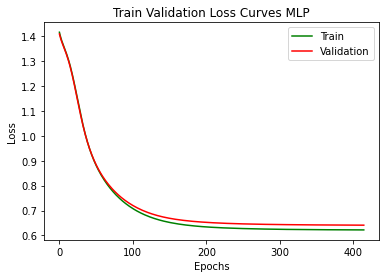

In [37]:
#getting values for train and validation loss
train_loss = model.best_estimator_.history[:,'train_loss']
valid_loss = model.best_estimator_.history[:,'valid_loss']

epochs = [i for i in range(len(model.best_estimator_.history))] #getting total number of epochs
plt.plot(epochs,train_loss,'g-'); #train loss
plt.plot(epochs,valid_loss,'r-'); #validation loss


plt.title('Train Validation Loss Curves MLP');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend(['Train','Validation']);

In [38]:
#predicting values using  test set

In [39]:
y_pred_mlp_test= model.predict(torch.from_numpy(X_test).float()) #predict on test


In [40]:
#plotting confusion matrix and classification report based on test data
print(confusion_matrix(y_test,y_pred_mlp_test)) #printing confusion matrix
print("\n")
print(classification_report(y_test,y_pred_mlp_test)) #printing classification report

print("Training set score for MLP: %f" % model.score(torch.from_numpy(X_train_res).float() ,torch.from_numpy(y_train_res).long()))
print("Testing  set score for MLP: %f" % model.score(torch.from_numpy(X_test).float()  , torch.from_numpy(y_test).long()))


[[ 309    0  444  314]
 [   0 1080    0    0]
 [   0    0   81    1]
 [ 156    0  201  654]]


              precision    recall  f1-score   support

           0       0.66      0.29      0.40      1067
           1       1.00      1.00      1.00      1080
           2       0.11      0.99      0.20        82
           3       0.67      0.65      0.66      1011

    accuracy                           0.66      3240
   macro avg       0.61      0.73      0.57      3240
weighted avg       0.77      0.66      0.68      3240

Training set score for MLP: 0.693622
Testing  set score for MLP: 0.677387


Calculating performance metrices on test data

In [41]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(torch.from_numpy(y_test).long(),y_pred_mlp_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(torch.from_numpy(y_test).long(),y_pred_mlp_test, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(torch.from_numpy(y_test).long(),y_pred_mlp_test,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(torch.from_numpy(y_test).long(),y_pred_mlp_test,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.655556
Precision: 0.612752
Recall: 0.655556
F1 score: 0.677387


In [42]:
#predicting value on test data
y_prob = model.predict_proba(torch.from_numpy(X_test).float())

Calculating the AUC-ROC Score on test data

In [43]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.911844 (macro),
0.903962 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.901489 (macro),
0.889155 (weighted by prevalence)


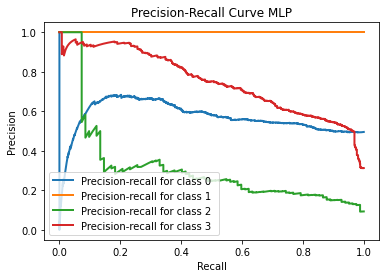

In [44]:
#plotting precision - recall curve 
from sklearn.metrics import precision_recall_curve
y_conv = label_binarize(y_test, classes=[0, 1, 2, 3]) #to convert output class of test data into binary
precision = dict() #empty dictionary
recall = dict() #empty dictionary
labels = []
for i in range(4):#as 4 output classes are there
    precision[i], recall[i], _ = precision_recall_curve(y_conv[:, i],y_prob[:, i]) #calculating values of precision and recall
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i)) #plotting the values
    labels.append('Precision-recall for class {0} '.format(i)) #setting label for legend

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve MLP')
plt.legend(labels)
plt.show()

Plotting roc curve for each class

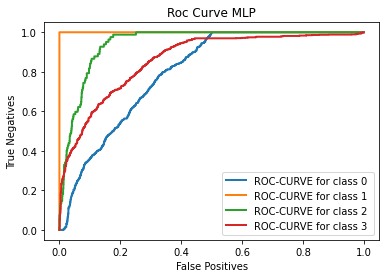

In [45]:

fpr = dict() #false positive
tpr = dict() #true positive
roc_auc = dict()
labels = []
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_conv[:, i], y_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0}'.format(i))
    labels.append('ROC-CURVE for class {} '.format(i))

plt.title('Roc Curve MLP')
plt.xlabel('False Positives')
plt.ylabel('True Negatives')
plt.legend(labels)
plt.show()    

Confusion matrix, without normalization for MLP
[[ 309    0  444  314]
 [   0 1080    0    0]
 [   0    0   81    1]
 [ 156    0  201  654]]
Normalized confusion matrix for MLP
[[0.289597   0.         0.41611996 0.29428304]
 [0.         1.         0.         0.        ]
 [0.         0.         0.98780488 0.01219512]
 [0.15430267 0.         0.19881306 0.64688427]]


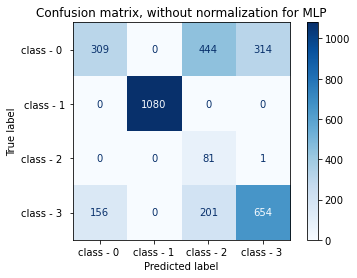

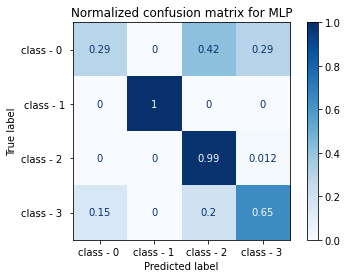

In [46]:
# Plot for confusion matrix on test data 

class_names = ['class - 0 ','class - 1','class - 2 ','class - 3 ']
titles_opt = [("Confusion matrix, without normalization for MLP", None),
                  ("Normalized confusion matrix for MLP", 'true')]
for title, normalize in titles_opt:
    disp = plot_confusion_matrix(model, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long(),
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

<H1> Model -2 SVM </H1>

Defining basic svm model

In [52]:
svclassifier = svm.SVC(kernel='linear') #svm model with linear classifier
svclassifier.fit(X_train_res, y_train_res) #fitting the model

SVC(kernel='linear')

In [53]:
# save the model to disk in pickle file
filename = 'svm_basic.sav'
pickle.dump(svclassifier, open(filename, 'wb'))


# load the model from disk
svclassifier = pickle.load(open(filename, 'rb'))

In [54]:
y_pred_svm_basic = svclassifier.predict(X_test) #predicting with test data


Confusion matrix, without normalization for SVM
[[ 415    0  301  351]
 [   0 1080    0    0]
 [   4    0   77    1]
 [ 220    0  130  661]]
Normalized confusion matrix for SVM
[[0.38894096 0.         0.28209934 0.3289597 ]
 [0.         1.         0.         0.        ]
 [0.04878049 0.         0.93902439 0.01219512]
 [0.21760633 0.         0.12858556 0.65380811]]


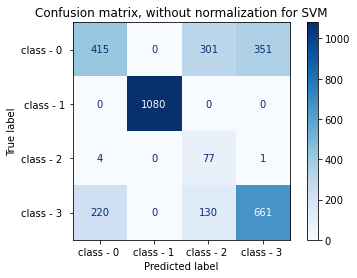

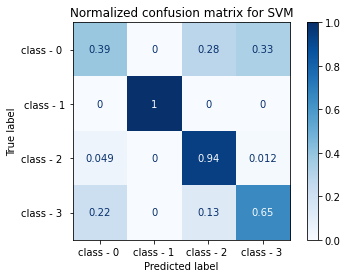

In [55]:
# confusion matrix on test data for a basic svm classifier
class_names = ['class - 0 ','class - 1','class - 2 ','class - 3 ']

#setting title value
titles_opt = [("Confusion matrix, without normalization for SVM", None),
                  ("Normalized confusion matrix for SVM", 'true')]


for title, normalize in titles_opt:
    disp = plot_confusion_matrix(svclassifier, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long(),
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Calculating performance metrices on basic svm model on test data

In [56]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(torch.from_numpy(y_test).long(),y_pred_svm_basic)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(torch.from_numpy(y_test).long(),y_pred_svm_basic, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(torch.from_numpy(y_test).long(),y_pred_svm_basic,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(torch.from_numpy(y_test).long(),y_pred_svm_basic,average='weighted')
print('F1 score: %f' % f1)
from sklearn.metrics import jaccard_score
jaccard_score = jaccard_score(torch.from_numpy(y_test).long(),y_pred_svm_basic,average='macro')
print('Jaccard Score: %f' % jaccard_score)

Accuracy: 0.689198
Precision: 0.613386
Recall: 0.689198
F1 score: 0.703971
Jaccard Score: 0.489128


<h1><b> Hyperparameter tuning using random search and cross validation </b></h1>

In [57]:
#passing parameters like kernel, c gamma into the grid search
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
               {'kernel':['poly'],'C': [1, 10, 100, 1000], 'degree':[3,4,2], 'gamma': [1e-3, 1e-4]}]

In [59]:
#using F1-Score as a scoring parameter
scoring = {
           'f1_score': make_scorer(recall_score, average = 'weighted')
           } 

#doing random search on svm parameters
svm_model = RandomizedSearchCV(svm.SVC(), params_grid, cv=5,scoring = scoring, refit='f1_score',n_jobs=-1)

#fitting the model
svm_model.fit(X_train_res, y_train_res)

#printing best parameters and score
print(svm_model.best_score_,svm_model.best_params_)

0.7621141975308641 {'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}


In [49]:
# save the model to disk in pickle file
filename = 'svm_model.sav'
# pickle.dump(svm_model, open(filename, 'wb'))


# load the model from disk
svm_model = pickle.load(open(filename, 'rb'))
svm_model

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions=[{'C': [1, 10, 100, 1000],
                                         'gamma': [0.001, 0.0001],
                                         'kernel': ['rbf']},
                                        {'C': [1, 10, 100, 1000],
                                         'kernel': ['linear']},
                                        {'C': [1, 10, 100, 1000],
                                         'degree': [3, 4, 2],
                                         'gamma': [0.001, 0.0001],
                                         'kernel': ['poly']}],
                   refit='f1_score',
                   scoring={'f1_score': make_scorer(recall_score, average=weighted)})

In [64]:
#building on best params obtained
svm_model = svm.SVC(kernel='rbf',C=1000,gamma=0.001,probability=True)
svm_model.fit(X_train_res, y_train_res)


SVC(C=1000, gamma=0.001, probability=True)

In [65]:
y_pred_svm = svm_model.predict(X_test)#on test data
y_prob_svm = svm_model.predict_proba(torch.from_numpy(X_test).float())

In [66]:

print(confusion_matrix(y_test,y_pred_svm))
print("\n")
print(classification_report(y_test,y_pred_svm))

print("Training set score for SVM: %f" % svm_model.score(X_train_res , y_train_res))
print("Testing  set score for SVM: %f" % svm_model.score(X_test  , y_test ))

# svm_model.score

[[ 460    0  300  307]
 [   0 1080    0    0]
 [   4    0   78    0]
 [ 228    0  127  656]]


              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1067
           1       1.00      1.00      1.00      1080
           2       0.15      0.95      0.27        82
           3       0.68      0.65      0.66      1011

    accuracy                           0.70      3240
   macro avg       0.63      0.76      0.61      3240
weighted avg       0.77      0.70      0.72      3240

Training set score for SVM: 0.765741
Testing  set score for SVM: 0.701852


Confusion matrix, without normalization for SVM
[[ 460    0  300  307]
 [   0 1080    0    0]
 [   4    0   78    0]
 [ 228    0  127  656]]
Normalized confusion matrix for SVM
[[0.43111528 0.         0.28116214 0.28772259]
 [0.         1.         0.         0.        ]
 [0.04878049 0.         0.95121951 0.        ]
 [0.22551929 0.         0.1256182  0.64886251]]


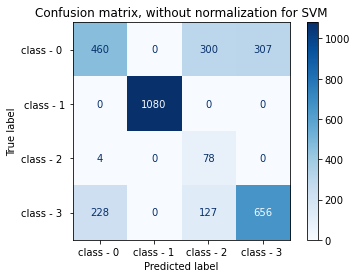

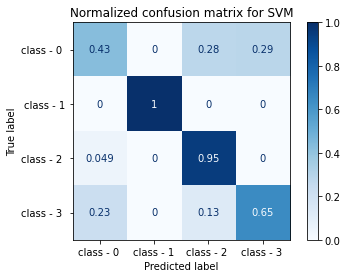

In [67]:
# Plot confusion matrix for test data
class_names = ['class - 0 ','class - 1','class - 2 ','class - 3 ']

#setting title
titles_opt = [("Confusion matrix, without normalization for SVM", None),
                  ("Normalized confusion matrix for SVM", 'true')]

for title, normalize in titles_opt:
    disp = plot_confusion_matrix(svm_model, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long(),
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Calculating performance metrices on test data

In [69]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(torch.from_numpy(y_test).long(),y_pred_svm)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(torch.from_numpy(y_test).long(),y_pred_svm, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(torch.from_numpy(y_test).long(),y_pred_svm,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(torch.from_numpy(y_test).long(),y_pred_svm,average='weighted')
print('F1 score: %f' % f1)
from sklearn.metrics import jaccard_score
jaccard_score = jaccard_score(torch.from_numpy(y_test).long(),y_pred_svm,average='macro')
print('Jaccard Score: %f' % jaccard_score)

Accuracy: 0.701852
Precision: 0.625100
Recall: 0.701852
F1 score: 0.719695
Jaccard Score: 0.501271


Plotting precision recall curve on test data

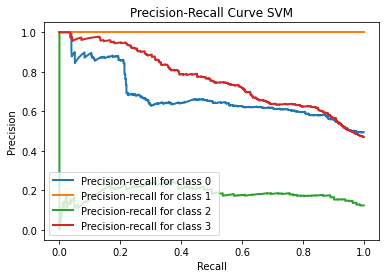

In [70]:
#plotting precision - recall curve 
from sklearn.metrics import precision_recall_curve
y_conv = label_binarize(y_test, classes=[0, 1, 2, 3]) #to convert output class of test data into binary
precision = dict() #empty dictionary
recall = dict() #empty dictionary
labels = []
for i in range(4):#as 4 output classes are there
    precision[i], recall[i], _ = precision_recall_curve(y_conv[:, i],y_prob_svm[:, i]) #calculating values of precision and recall
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i)) #plotting the values
    labels.append('Precision-recall for class {0} '.format(i)) #setting label for legend

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVM')
plt.legend(labels)
plt.show()

Plotting ROC curve for test data

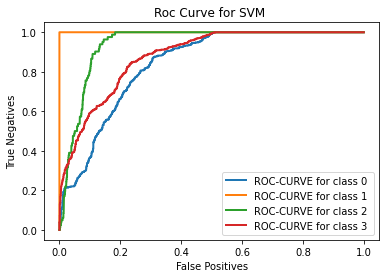

In [71]:
fpr = dict() #false positive
tpr = dict() #true positive
roc_auc = dict() #roc value
labels = []
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_conv[:, i], y_prob_svm[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0}'.format(i))
    labels.append('ROC-CURVE for class {} '.format(i))

plt.title('Roc Curve for SVM ')
plt.xlabel('False Positives')
plt.ylabel('True Negatives')
plt.legend(labels)
plt.show()    

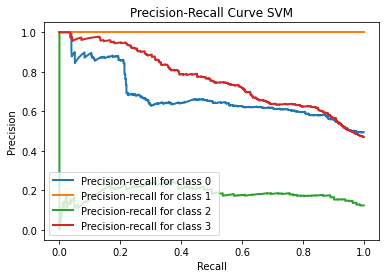

In [72]:
#plotting precision - recall curve 
from sklearn.metrics import precision_recall_curve
y_conv = label_binarize(y_test, classes=[0, 1, 2, 3]) #to convert output class of test data into binary
precision = dict() #empty dictionary
recall = dict() #empty dictionary
labels = []
for i in range(4):#as 4 output classes are there
    precision[i], recall[i], _ = precision_recall_curve(y_conv[:, i],y_prob_svm[:, i]) #calculating values of precision and recall
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i)) #plotting the values
    labels.append('Precision-recall for class {0} '.format(i)) #setting label for legend

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVM')
plt.legend(labels)
plt.show()

In [73]:
#calculating auc-roc value
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob_svm, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob_svm, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob_svm, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob_svm, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.916409 (macro),
0.913348 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.914368 (macro),
0.907684 (weighted by prevalence)
